# Bayesian Network Modelling and Classification of Credit Risk

This notebook examines the use of Bayesian Networks for probabilistic modeling of credit data and classification of risk. 

## Table of Contents
1. Dataset
2. Imports
3. Data Exploration
4. Exploratory Data Analysis
5. Preprocessing
6. Classification Models
7. Bayesian Network Modeling


# 1. Dataset
The dataset used was obtained from Kaggle at https://www.kaggle.com/uciml/german-credit. It is a simplified version of the original data originally found on the UCI repository.
Each data entry represents a borrower taking a loan from the bank, with an assigned risk (good or bad).

The features include:
1. **Age** - (Numeric) integer
2. **Sex** - (male, female) object
3. **Job** - integer
    - **1**: Unskilled and non-resident
    - **2**: Unskilled and resident
    - **3**: Skilled
    - **4**: Highly skilled             
4. **Housing** - object
    - **own**
    - **rent**
    - **free**
5. **Saving accounts** - object
    - **little**
    - **moderate**
    - **quite rich**
    - **rich**
6. **Checking account** - (Deutsch Mark) integer
7. **Credit amount** - (Deutsch Mark) integer
8. **Duration** - (Months) integer
9. **Purpose** -object
    - **car**
    - **furniture/equipment**
    - **radio/TV**
    - **domestic appliances**
    - **repairs**
    - **education**
    - **business**
    - **vacation/others**
10. **Risk** - (Target Variable)object
    - **Good**
    - **Bad**

# 2. Imports

In [1]:
# Data handling and processing libraries
import pandas as pd
import numpy as np
import scipy.stats as ss
import missingno as msno
import category_encoders as ce

# Bayesian Network libraries
from pgmpy.estimators import HillClimbSearch, MaximumLikelihoodEstimator, BicScore, K2Score
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination
from feature_engine import discretisation as disc
import networkx as nx
import pylab as plt
import time

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
%config InlineBackend.figure_format='retina'

# Naive Bayes libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import CategoricalNB

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve 
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn import metrics

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from matplotlib import pyplot

import warnings
warnings.filterwarnings('ignore')

# 3. Model Exploration
### 3.1 Load data

In [2]:
df = pd.read_csv("german_credit_data.csv")
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


### 3.2 Data Summary

In [3]:
df.dtypes

Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
Risk                object
dtype: object

In [4]:
# Statistical summary
df.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


In [5]:
# Missing values
df.isna().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

# 4. Exploratory Data Analysis
### 4.1  Numerical features

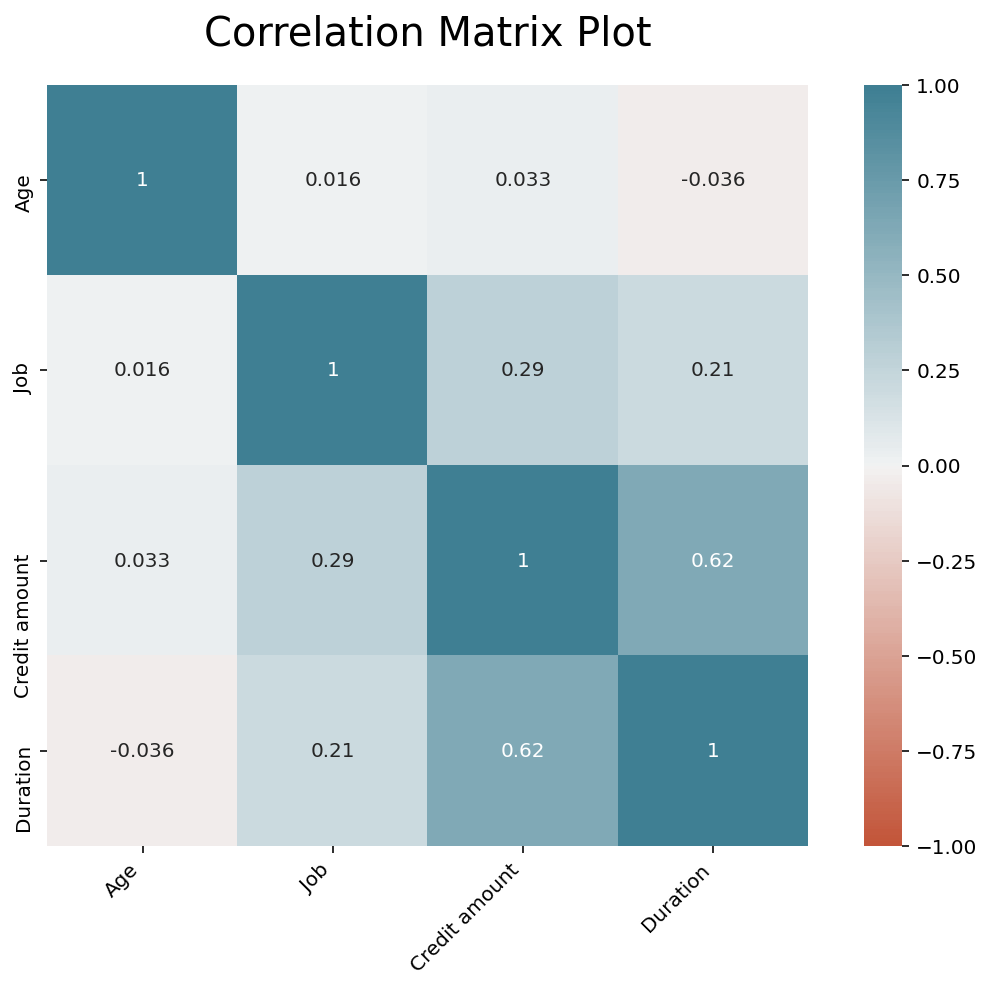

In [6]:
# Correlation matrix
corr = df.corr()
plt.figure(figsize=(10,7))
ax = sns.heatmap(corr,
                 vmin=-1, 
                 vmax=1, 
                 center=0,
                 cmap=sns.diverging_palette(20, 220, n=200),
                 square=True,
                 annot=True)
                  
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right')

ax.set_title('Correlation Matrix Plot', fontdict={'fontsize':20}, pad=20);

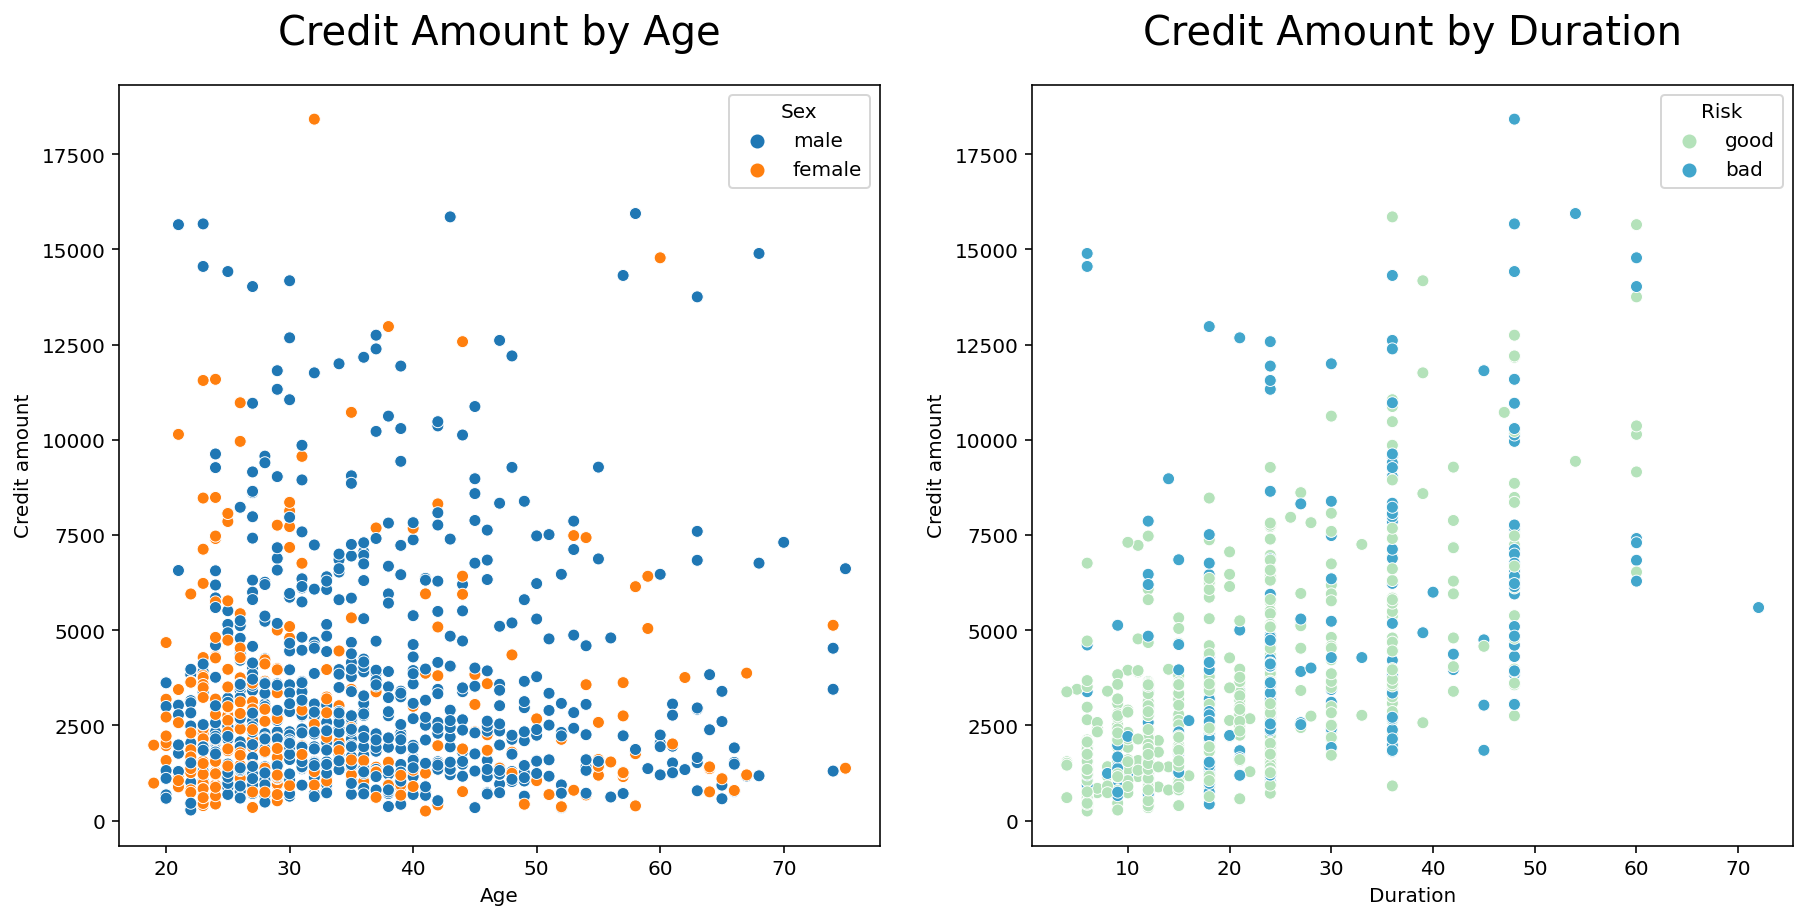

In [7]:
# Scatter plot between Age and Credit amount
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2,figsize=(15,7))

sns.scatterplot(data=df, x='Age', y='Credit amount', hue='Sex', ax=ax1);
sns.scatterplot(data=df, x='Duration', y='Credit amount', hue='Risk', ax=ax2, palette='GnBu' );
ax1.set_title('Credit Amount by Age', fontdict={'fontsize':20}, pad=20);
ax2.set_title('Credit Amount by Duration', fontdict={'fontsize':20}, pad=20);

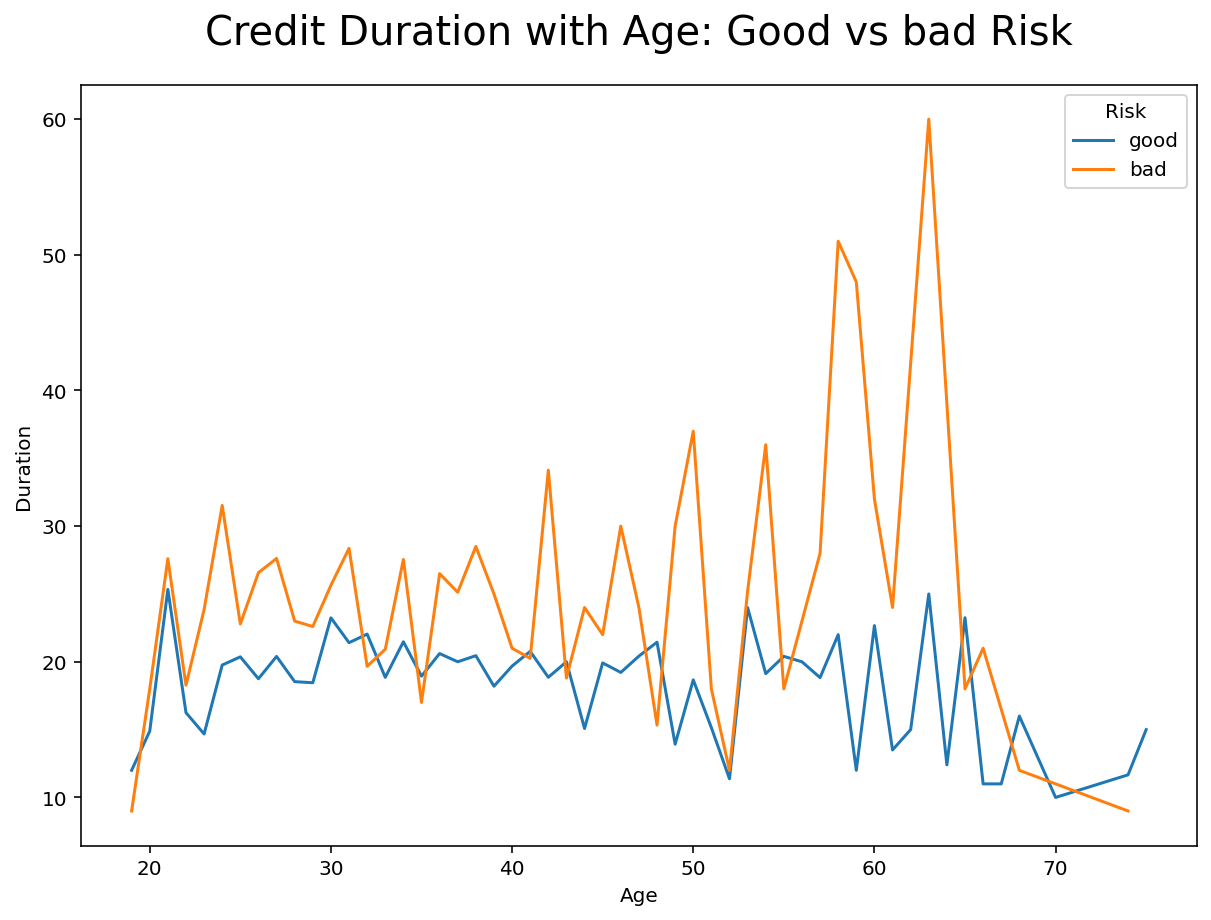

In [8]:
plt.figure(figsize=(10,7))
#sns.lineplot(data=df, x='Duration', y='Credit amount', hue='Risk', err_style=None);
sns.lineplot(data=df, x='Age', y='Duration', hue='Risk', err_style=None);
plt.title('Credit Duration with Age: Good vs bad Risk', fontdict={'fontsize':20}, pad=20);

### 4.2 Categorical features

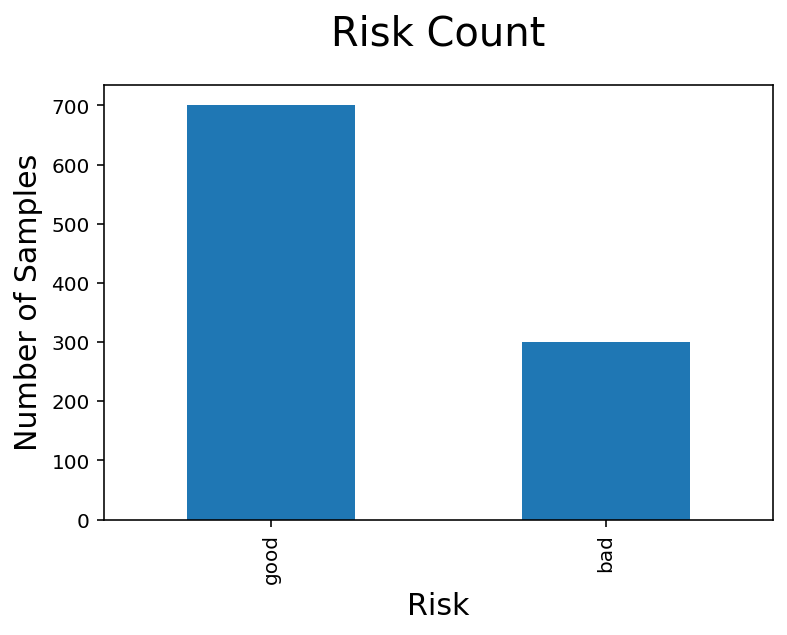

In [50]:
df['Risk'].value_counts().plot(kind='bar');
plt.title('Risk Count', fontdict={'fontsize':20}, pad=20);
plt.xlabel('Risk', size=15);
plt.ylabel('Number of Samples', size=15);

In [51]:
df.Risk.value_counts()

good    700
bad     300
Name: Risk, dtype: int64

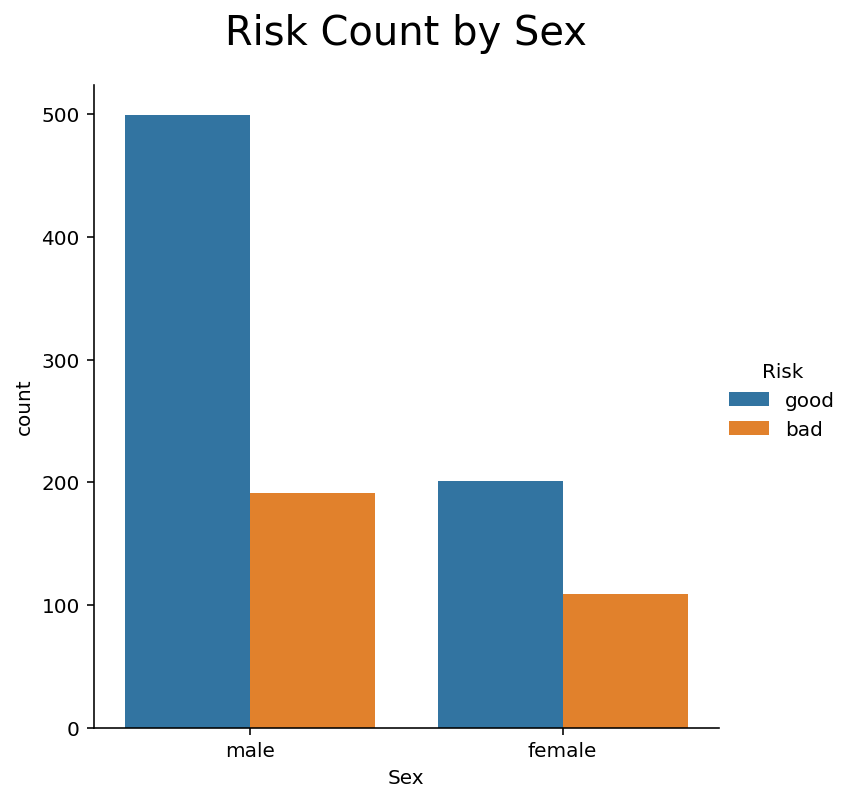

In [10]:
sns.catplot(data=df, kind='count', x='Sex', hue='Risk');
plt.title('Risk Count by Sex', fontdict={'fontsize':20}, pad=20);

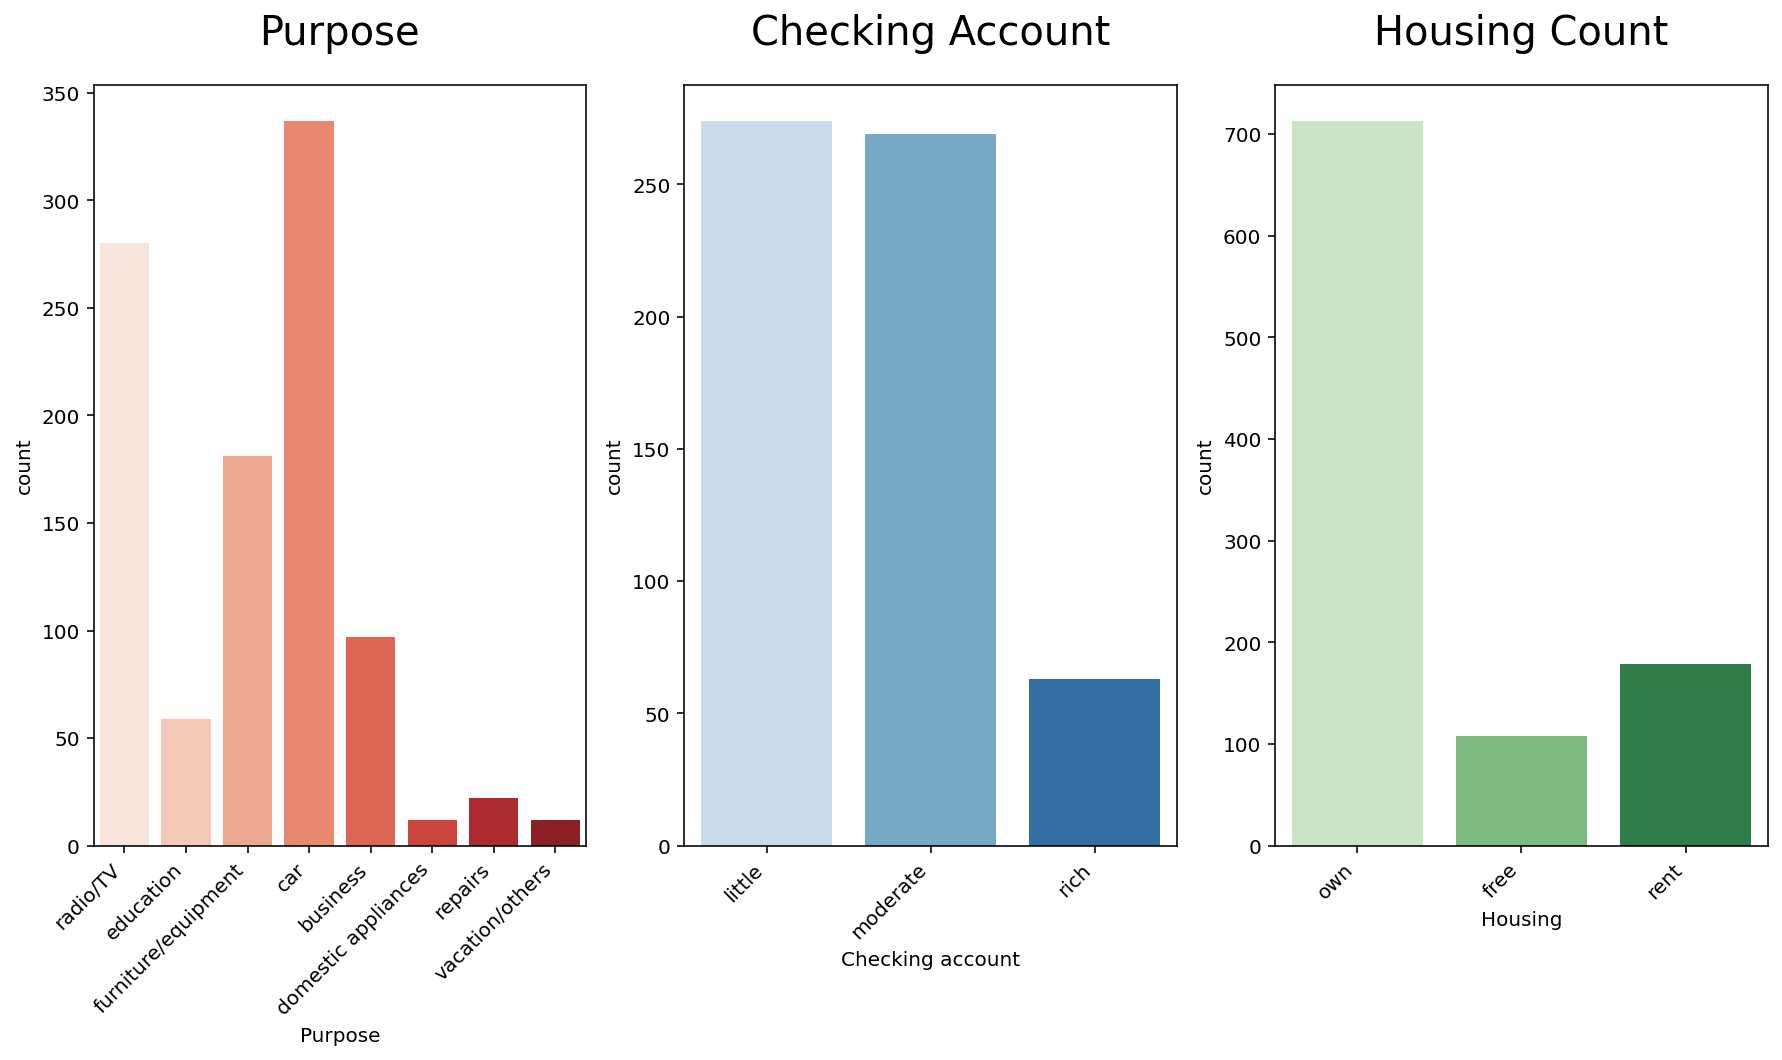

In [11]:
fig, (ax1,ax2, ax3) = plt.subplots(nrows=1, ncols=3,figsize=(15,7))

sns.countplot(data=df, x='Purpose', ax=ax1,palette='Reds');
sns.countplot(data=df, x='Checking account', ax=ax2, palette='Blues');
sns.countplot(data=df, x='Housing', ax=ax3, palette='Greens');

ax1.set_title('Purpose', fontdict={'fontsize':20}, pad=20);
ax2.set_title('Checking Account', fontdict={'fontsize':20}, pad=20);
ax3.set_title('Housing Count', fontdict={'fontsize':20}, pad=20);

for each in [ax1,ax2,ax3]:
    each.set_xticklabels(each.get_xticklabels(),
                         rotation=45,
                         horizontalalignment='right')


### 4.3 Feature Distributions

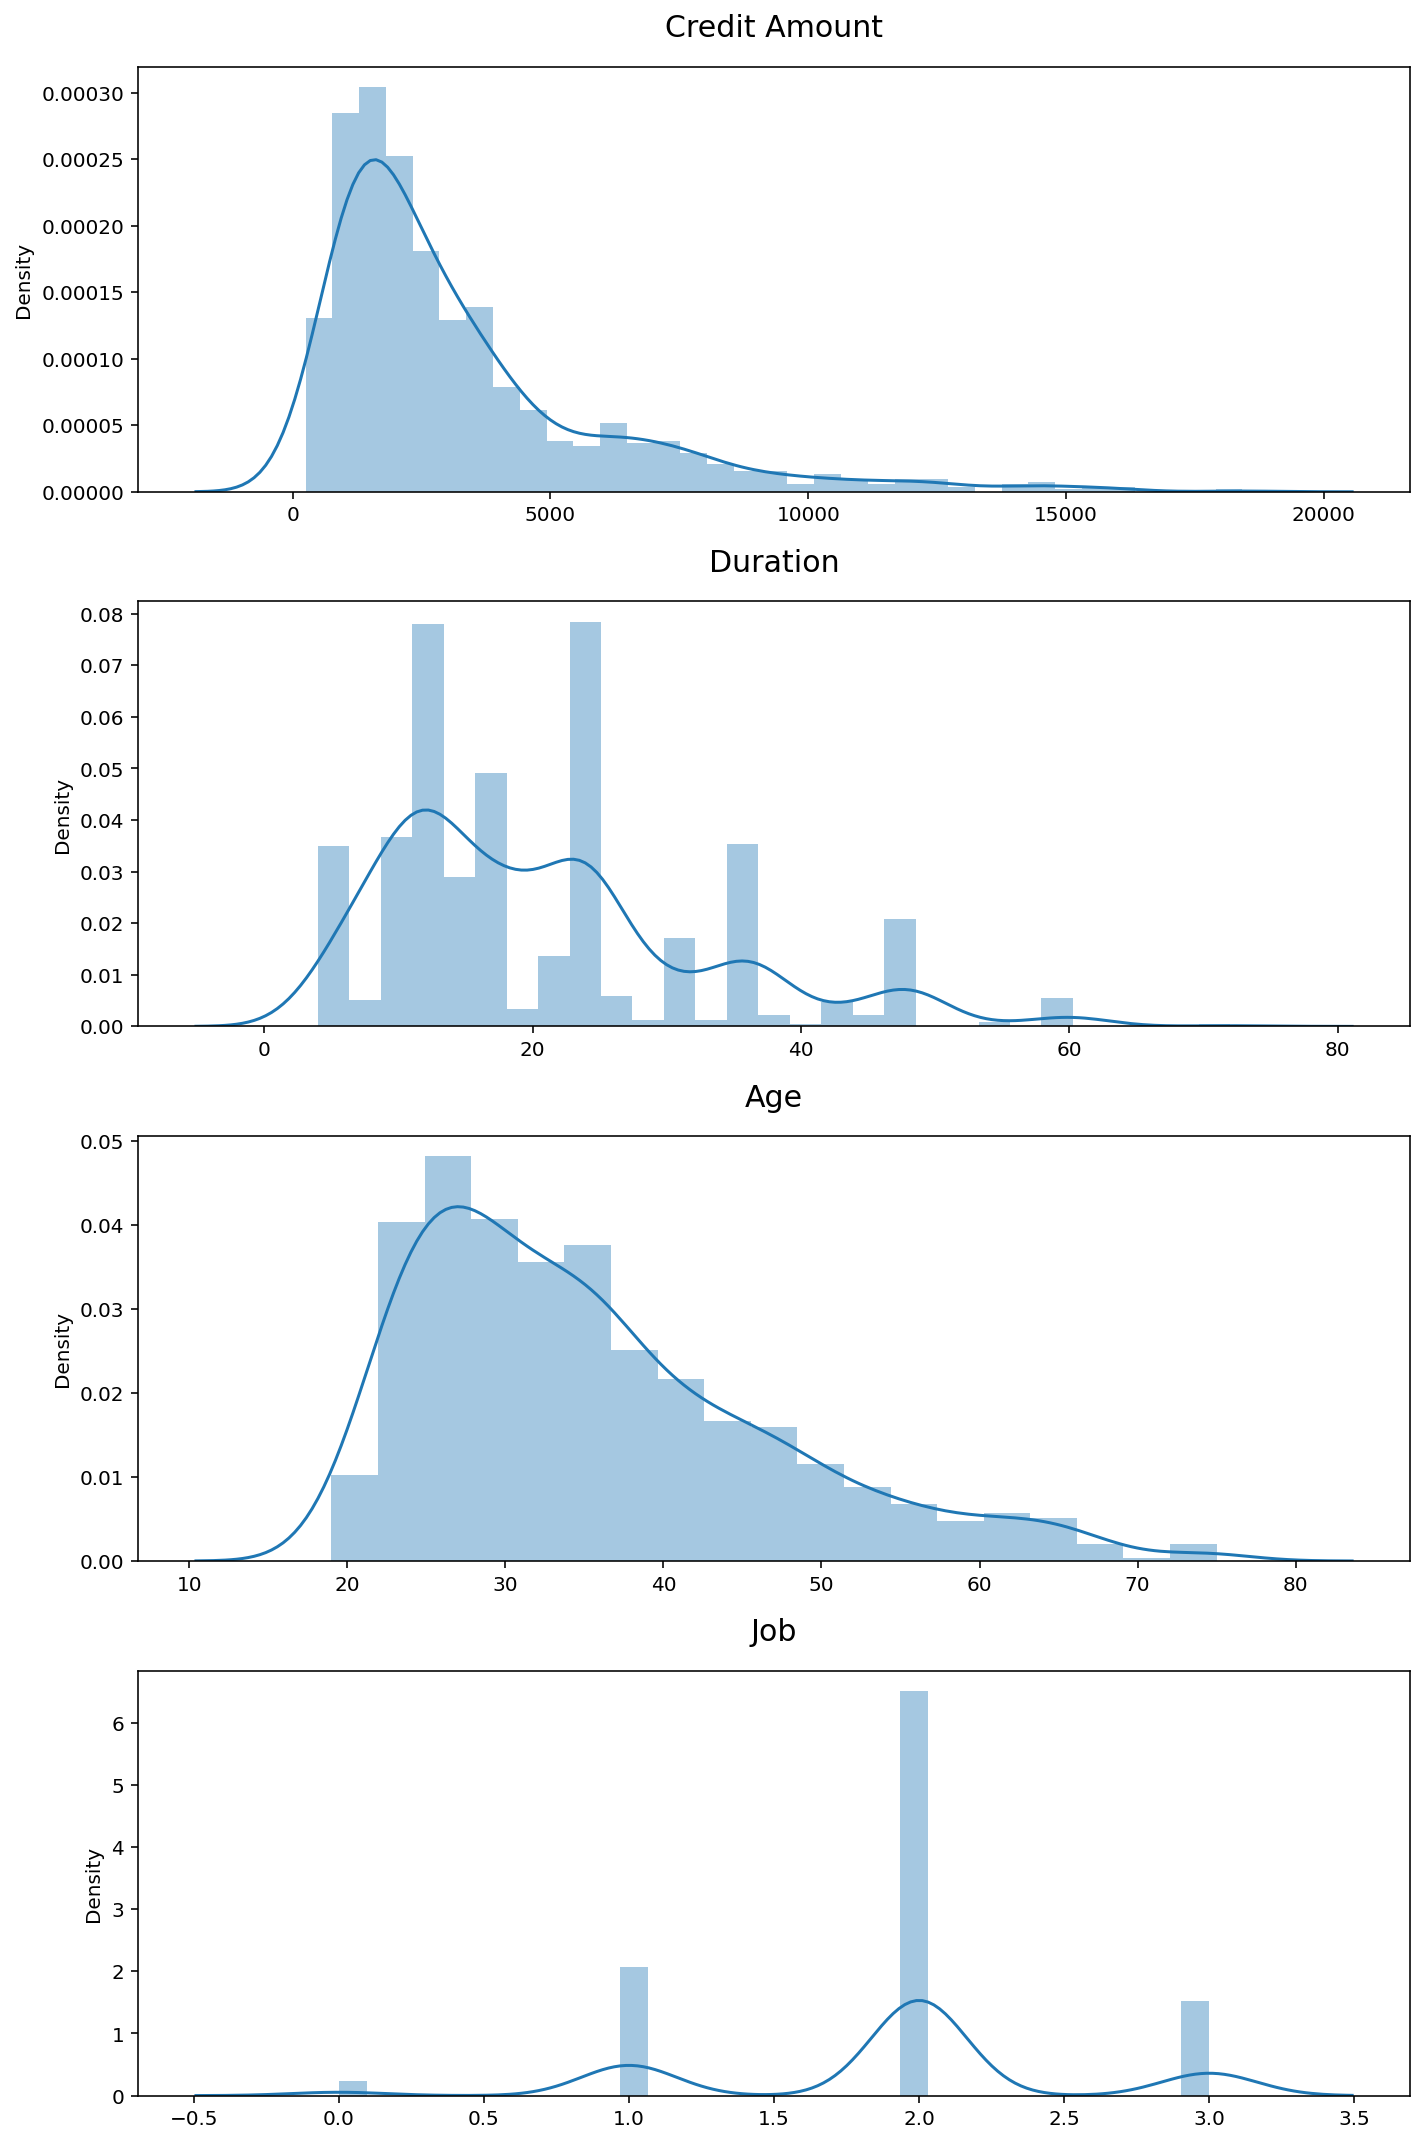

In [12]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(10,15),sharex=False,squeeze=True)

sns.distplot(x=df['Credit amount'], kde=True, ax=ax1);
sns.distplot(x=df['Duration'], kde=True, ax=ax2);
sns.distplot(x=df['Age'], kde=True, ax=ax3);
sns.distplot(x=df['Job'], kde=True, ax=ax4);

ax1.set_title('Credit Amount', fontdict={'fontsize':15}, pad=15);
ax2.set_title('Duration', fontdict={'fontsize':15}, pad=15);
ax3.set_title('Age', fontdict={'fontsize':15}, pad=15);
ax4.set_title('Job', fontdict={'fontsize':15}, pad=15);
fig.tight_layout()

### 4.4 Missing Values Check

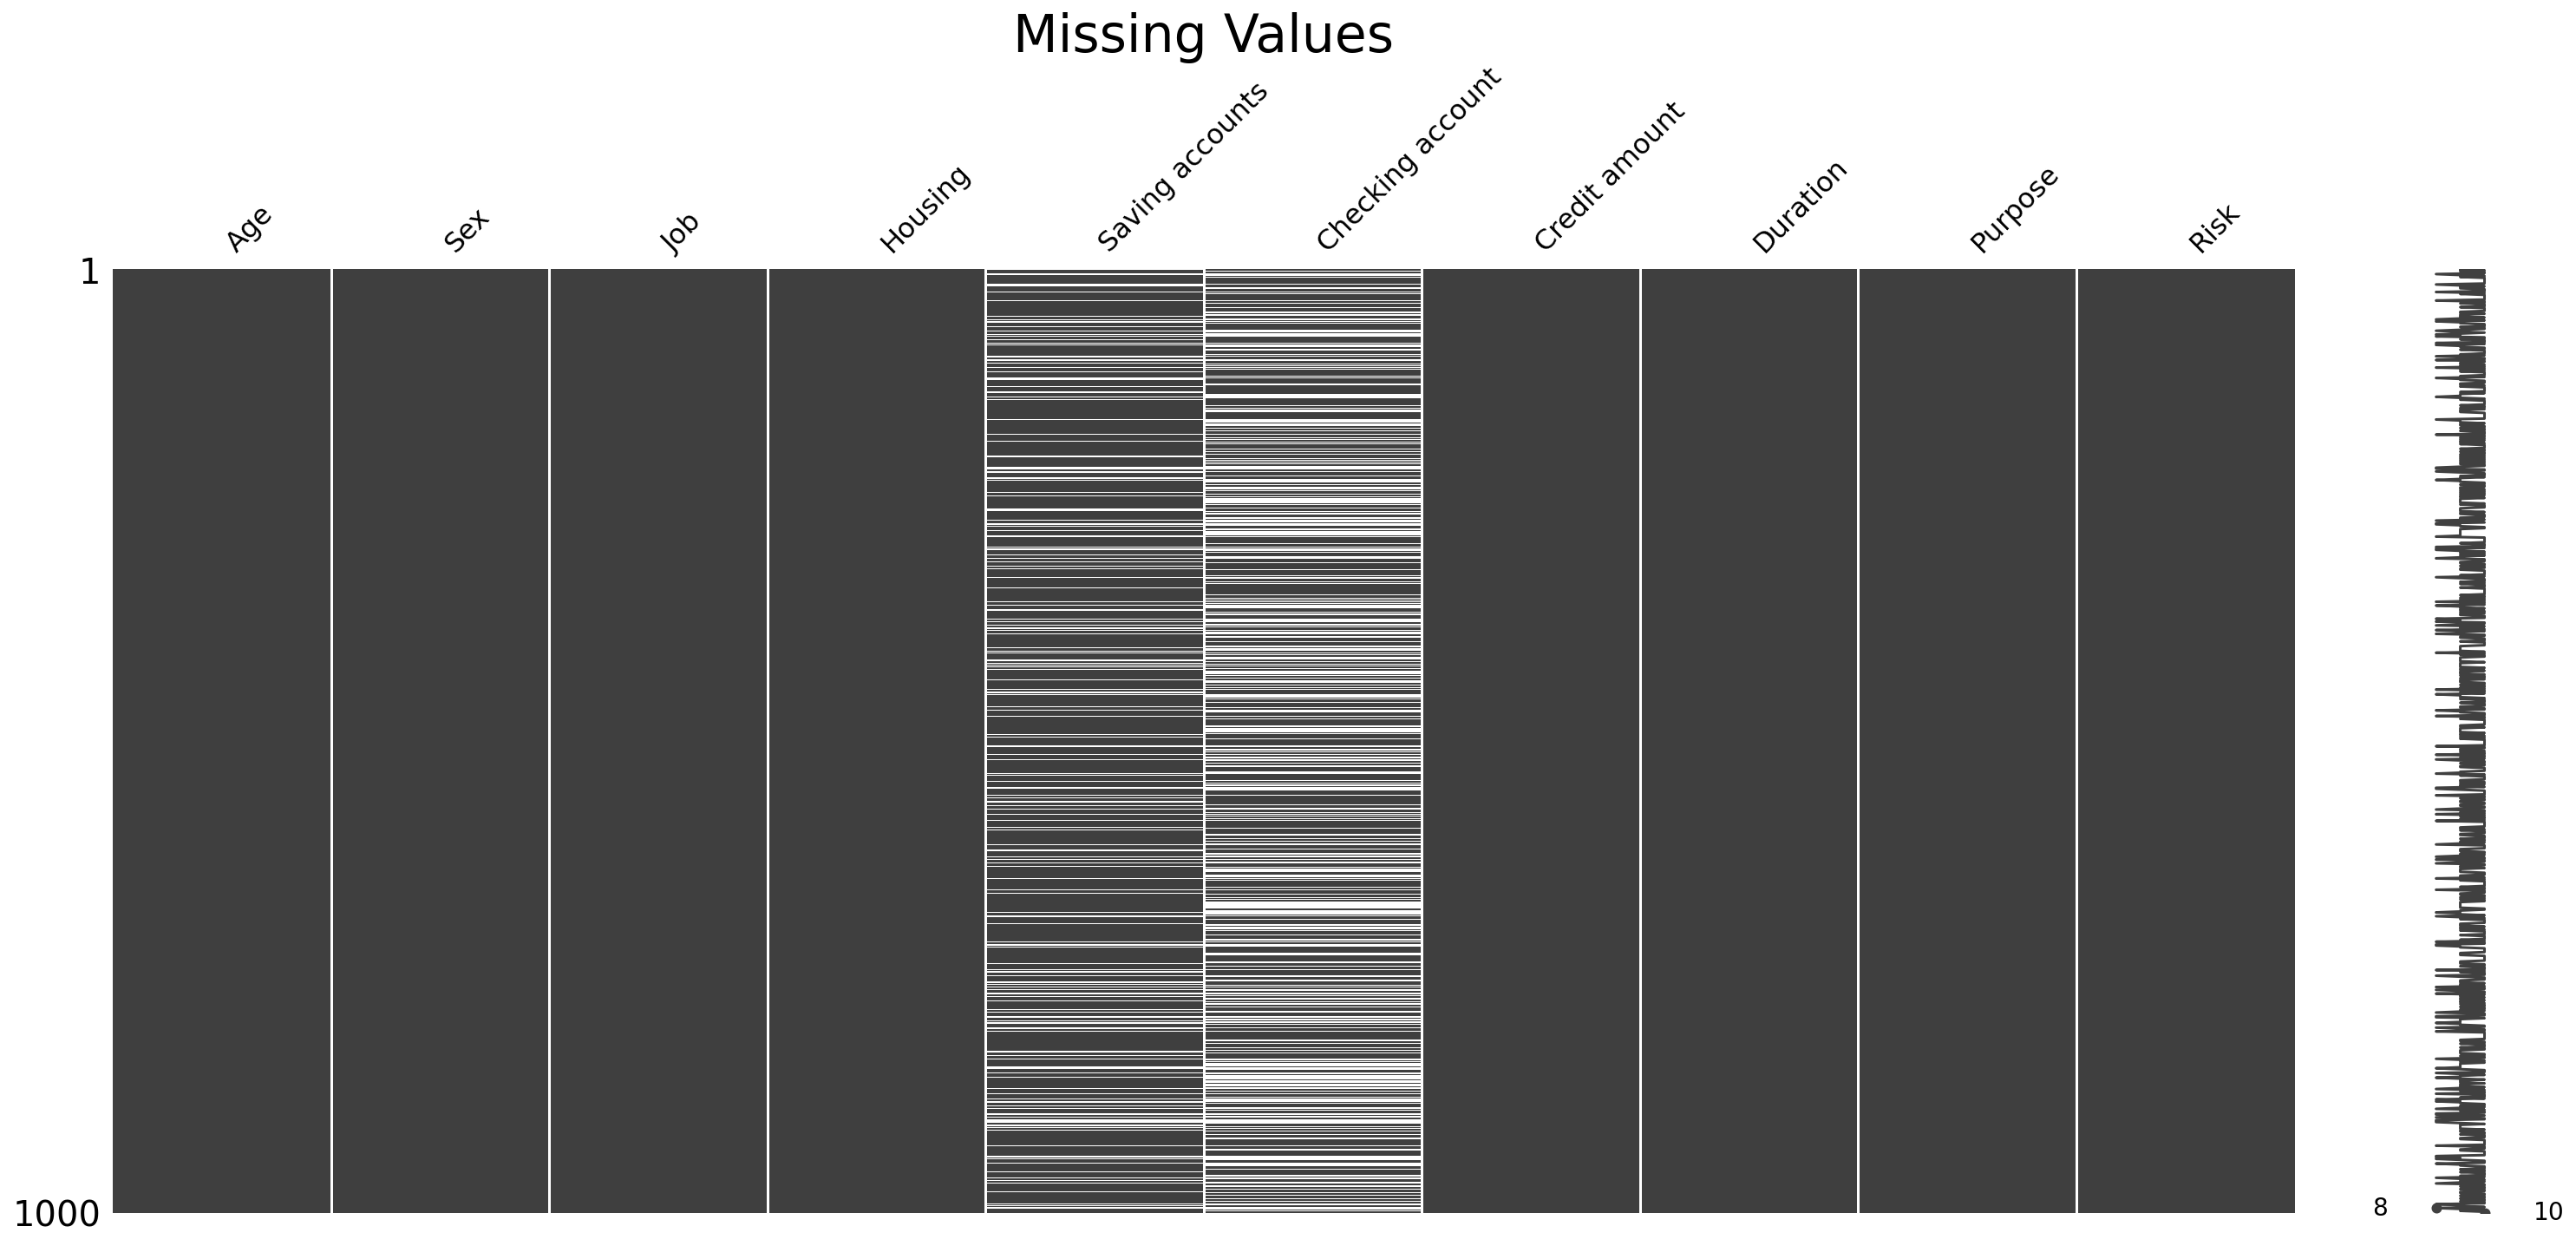

In [13]:
msno.matrix(df)
plt.title('Missing Values', size=30);

# 5. Preprocessing
### 5.1. Rectify missing values
The null values for `Savings accounts` and `Checking account` are actually valid, and simply suggest that the person has neither of those accounts. Missing values in these fields can thus be replaced with `None` category

In [14]:
df.loc[df['Saving accounts'].isna(), 'Saving accounts'] = 'none'
df.loc[df['Checking account'].isna(), 'Checking account'] = 'none'

In [15]:
df.isna().sum() 

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64

Bayesian Networks, unlike the other classifying algorithms, requires all the features to be categorical. 

This means the data will be preprocessed to support this condition

### 5.2. Categorize numerical values

In [16]:
# Categorize Ages
ages = (18, 25, 35, 60, 77)
buckets = ['Student', 'YoungAdult', 'MiddleAged', 'Elderly']

df["age_group"] = pd.cut(df['Age'], 
                         ages, 
                         labels=buckets)

# Categorize Credit Amount
amounts = (249, 1365.5, 2319.5, 3972.25, 18425)
buckets = ['lowest', 'low', 'high', 'highest']

df["credit_range"] = pd.cut(df['Credit amount'], 
                            amounts, 
                            labels=buckets)

# Discretize Duration
durations = (3, 12, 18, 24, 73)
buckets = ['shortest', 'short', 'long', 'longest']

df["duration_range"] = pd.cut(df['Duration'], 
                              durations, 
                              labels=buckets)

In [17]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,age_group,credit_range,duration_range
0,67,male,2,own,none,little,1169,6,radio/TV,good,Elderly,lowest,shortest
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad,Student,highest,longest
2,49,male,1,own,little,none,2096,12,education,good,MiddleAged,low,shortest
3,45,male,2,free,little,little,7882,42,furniture/equipment,good,MiddleAged,highest,longest
4,53,male,2,free,little,little,4870,24,car,bad,MiddleAged,highest,long


# 6. Classification Algorithms

### 6.1 Categorical Encoding:

In [18]:
encoder = ce.OrdinalEncoder(cols=['Saving accounts','Checking account','credit_range','duration_range','age_group'],return_df=True,
                            mapping=[{'col':'Saving accounts',
                                     'mapping':{'none':0,'little':1,'moderate':2,'quite rich':3,'rich':4}},
                                     {'col':'Checking account',
                                     'mapping':{'none':0,'little':1,'moderate':2,'rich':3}},
                                     {'col':'credit_range',
                                     'mapping':{'lowest':1,'low':2,'high':3,'highest':4}},
                                     {'col':'duration_range',
                                     'mapping':{'shortest':1,'short':2,'long':3,'longest':4}},
                                     {'col':'age_group',
                                     'mapping':{'Student':1,'YoungAdult':2,'MiddleAged':3,'Elderly':4}}])
                                     


df1 = df.drop(["Age","Credit amount","Duration"], axis=1)

df1 = df1.replace({'Risk':{'good':0, 'bad':1},
                   'Saving accounts':{'none':0,'little':1,'moderate':2,'quite rich':3,'rich':4},
                   'Checking account':{'none':0,'little':1,'moderate':2,'rich':3},
                   'credit_range':{'lowest':1,'low':2,'high':3,'highest':4},
                   'duration_range':{'shortest':1,'short':2,'long':3,'longest':4},
                   'age_group':{'Student':1,'YoungAdult':2,'MiddleAged':3,'Elderly':4}})
                           

df2 = pd.get_dummies(df1, columns=['Sex',
                                   'Housing',
                                   'Purpose'])
                

In [19]:
df2.head()

,Job,Saving accounts,Checking account,Risk,age_group,credit_range,duration_range,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,2,0,1,0,4,1,1,0,1,0,1,0,0,0,0,0,0,1,0,0
1,2,1,2,1,1,4,4,1,0,0,1,0,0,0,0,0,0,1,0,0
2,1,1,0,0,3,2,1,0,1,0,1,0,0,0,0,1,0,0,0,0
3,2,1,1,0,3,4,4,0,1,1,0,0,0,0,0,0,1,0,0,0
4,2,1,1,1,3,4,3,0,1,1,0,0,0,1,0,0,0,0,0,0


In [20]:
df2.dtypes

Job                            int64
Saving accounts                int64
Checking account               int64
Risk                           int64
age_group                      int64
credit_range                   int64
duration_range                 int64
Sex_female                     uint8
Sex_male                       uint8
Housing_free                   uint8
Housing_own                    uint8
Housing_rent                   uint8
Purpose_business               uint8
Purpose_car                    uint8
Purpose_domestic appliances    uint8
Purpose_education              uint8
Purpose_furniture/equipment    uint8
Purpose_radio/TV               uint8
Purpose_repairs                uint8
Purpose_vacation/others        uint8
dtype: object

### 6.2.  Split dataset

In [21]:
X = df2.drop(["Risk"], axis=1)
y = df2["Risk"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=7)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(800, 19)
(800,)
(200, 19)
(200,)


### 6.3. Build model

In [22]:
mnb = MultinomialNB()
mnb_model = mnb.fit(X_train, y_train)

comp_nb = ComplementNB()
comp_nb_model = comp_nb.fit(X_train, y_train)

cat_nb = CategoricalNB()
cat_nb_model = cat_nb.fit(X_train, y_train)



### 6.4. Evaluation functions

In [56]:
def evaluation(model, X_test, y_test):
    for model_name, each in zip(model.keys(), model.values()):
        plot_roc_curve(each, X_test, y_test)
        plt.plot([0, 1], [0, 1],'r--');

        y_pred = each.predict(X_test)
        print(f'Classification Report for: {model_name}')
        print(classification_report(y_test, y_pred))
        print('----------------------------------------------------')
        plot_conf_mat(y_test, y_pred)
        
def plot_conf_mat(y_test, y_preds):
    fig, ax = plt.subplots(figsize=(5,5))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds), 
                     fmt='g',
                     cmap=sns.color_palette("crest", as_cmap=True),
                     annot=True,
                     cbar=True)
    plt.ylabel("True label", size=15)
    plt.xlabel("Predicted label", size=15)

### 6.5 Fit and Evaluate models

Classification Report for: Multinomial Naive Bayes
              precision    recall  f1-score   support

           0       0.78      0.98      0.87       149
           1       0.77      0.20      0.31        51

    accuracy                           0.78       200
   macro avg       0.77      0.59      0.59       200
weighted avg       0.78      0.78      0.73       200

----------------------------------------------------


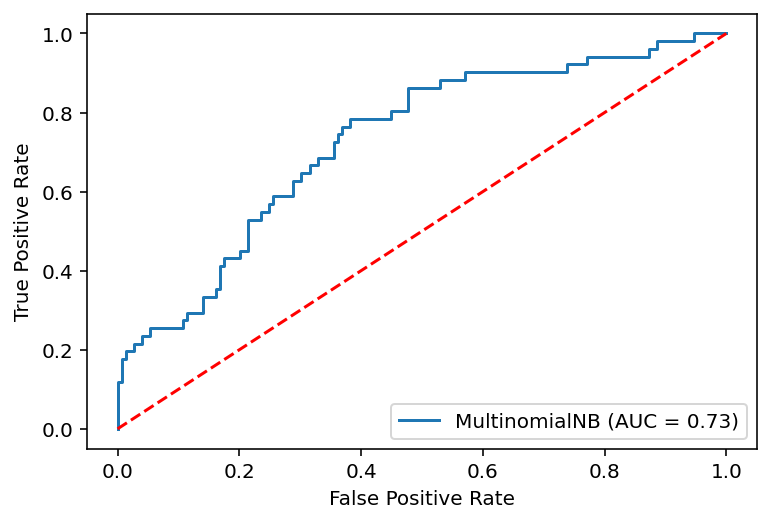

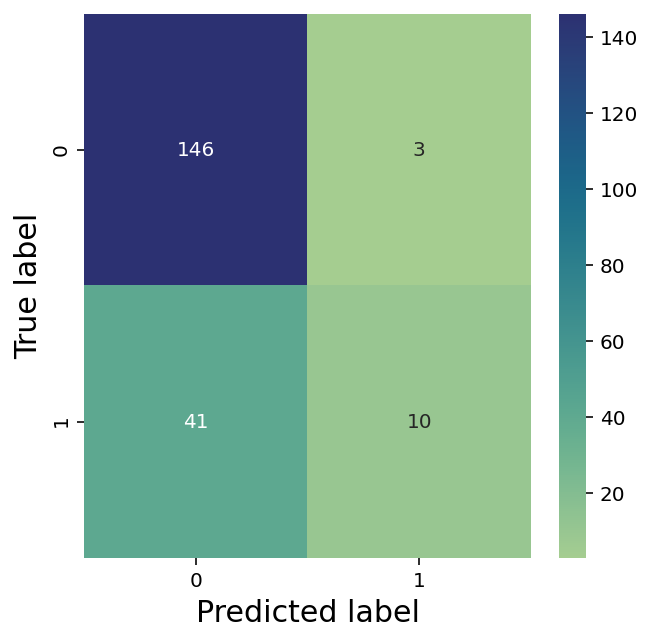

In [57]:
evaluation({"Multinomial Naive Bayes": mnb_model}, X_test, y_test)

Classification Report for: Complement Naive Bayes
              precision    recall  f1-score   support

           0       0.87      0.64      0.74       149
           1       0.41      0.73      0.52        51

    accuracy                           0.67       200
   macro avg       0.64      0.68      0.63       200
weighted avg       0.76      0.67      0.69       200

----------------------------------------------------


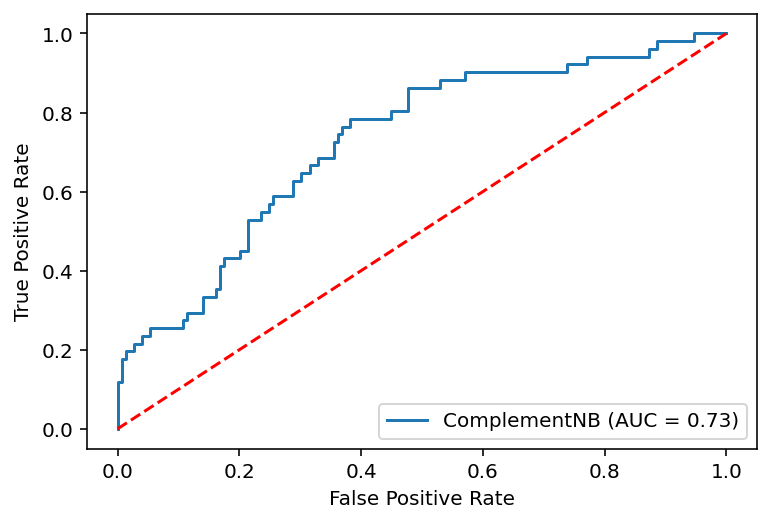

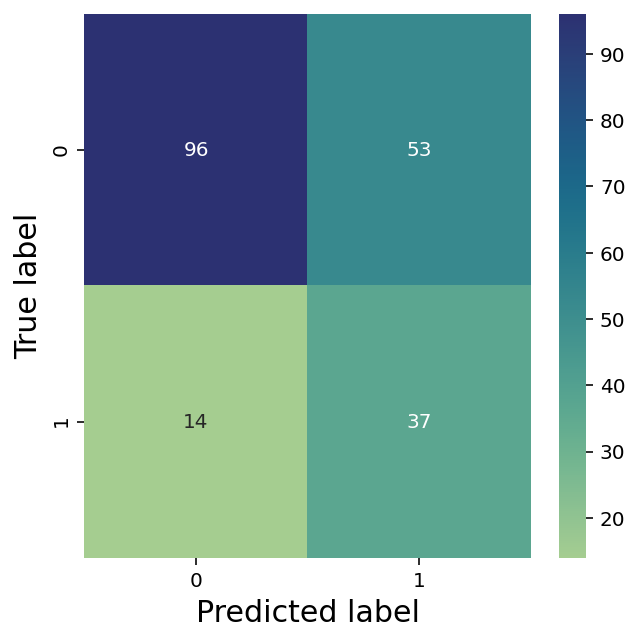

In [58]:
evaluation({"Complement Naive Bayes": comp_nb_model}, X_test,y_test)

Classification Report for: Categorical Naive Bayes
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       149
           1       0.60      0.55      0.57        51

    accuracy                           0.79       200
   macro avg       0.72      0.71      0.72       200
weighted avg       0.78      0.79      0.79       200

----------------------------------------------------


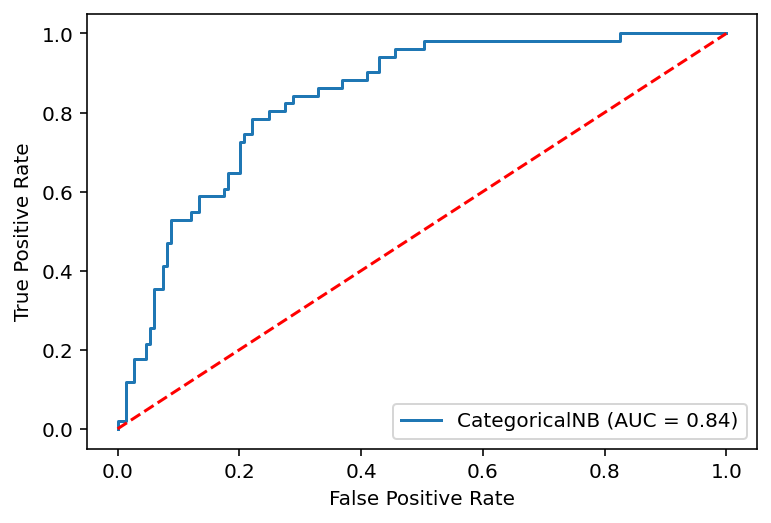

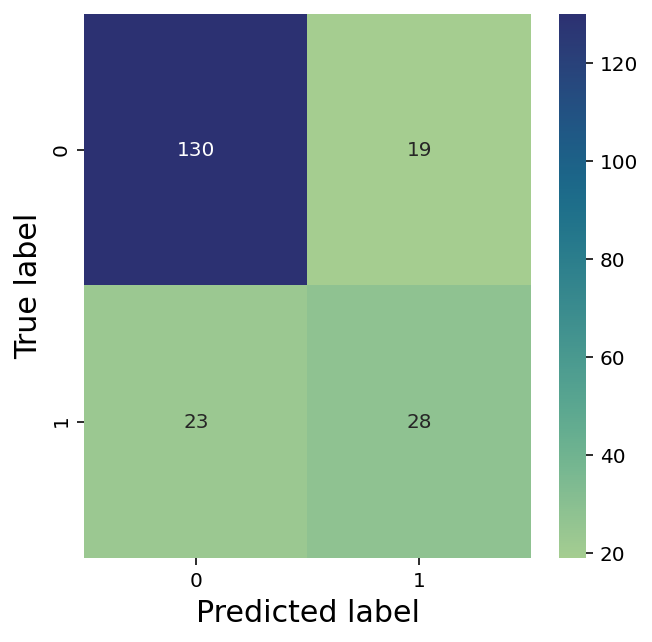

In [59]:
evaluation({"Categorical Naive Bayes": cat_nb_model}, X_test,y_test)

# 7. Bayesian Network Modelling

In [66]:
#df_train = pd.merge(X_train, y_train, left_index=True, right_index=True)
#df_test = pd.merge(X_test, y_test, left_index=True, right_index=True)

df_train = df.drop(["Age","Credit amount","Duration"], axis=1)[:800]
df_test = df.drop(["Age","Credit amount","Duration"], axis=1)[800:]
print(df.shape)
print(df_train.shape)
print(df_test.shape)

(1000, 13)
(800, 10)
(200, 10)


  0%|          | 10/1000000 [00:02<77:01:46,  3.61it/s]


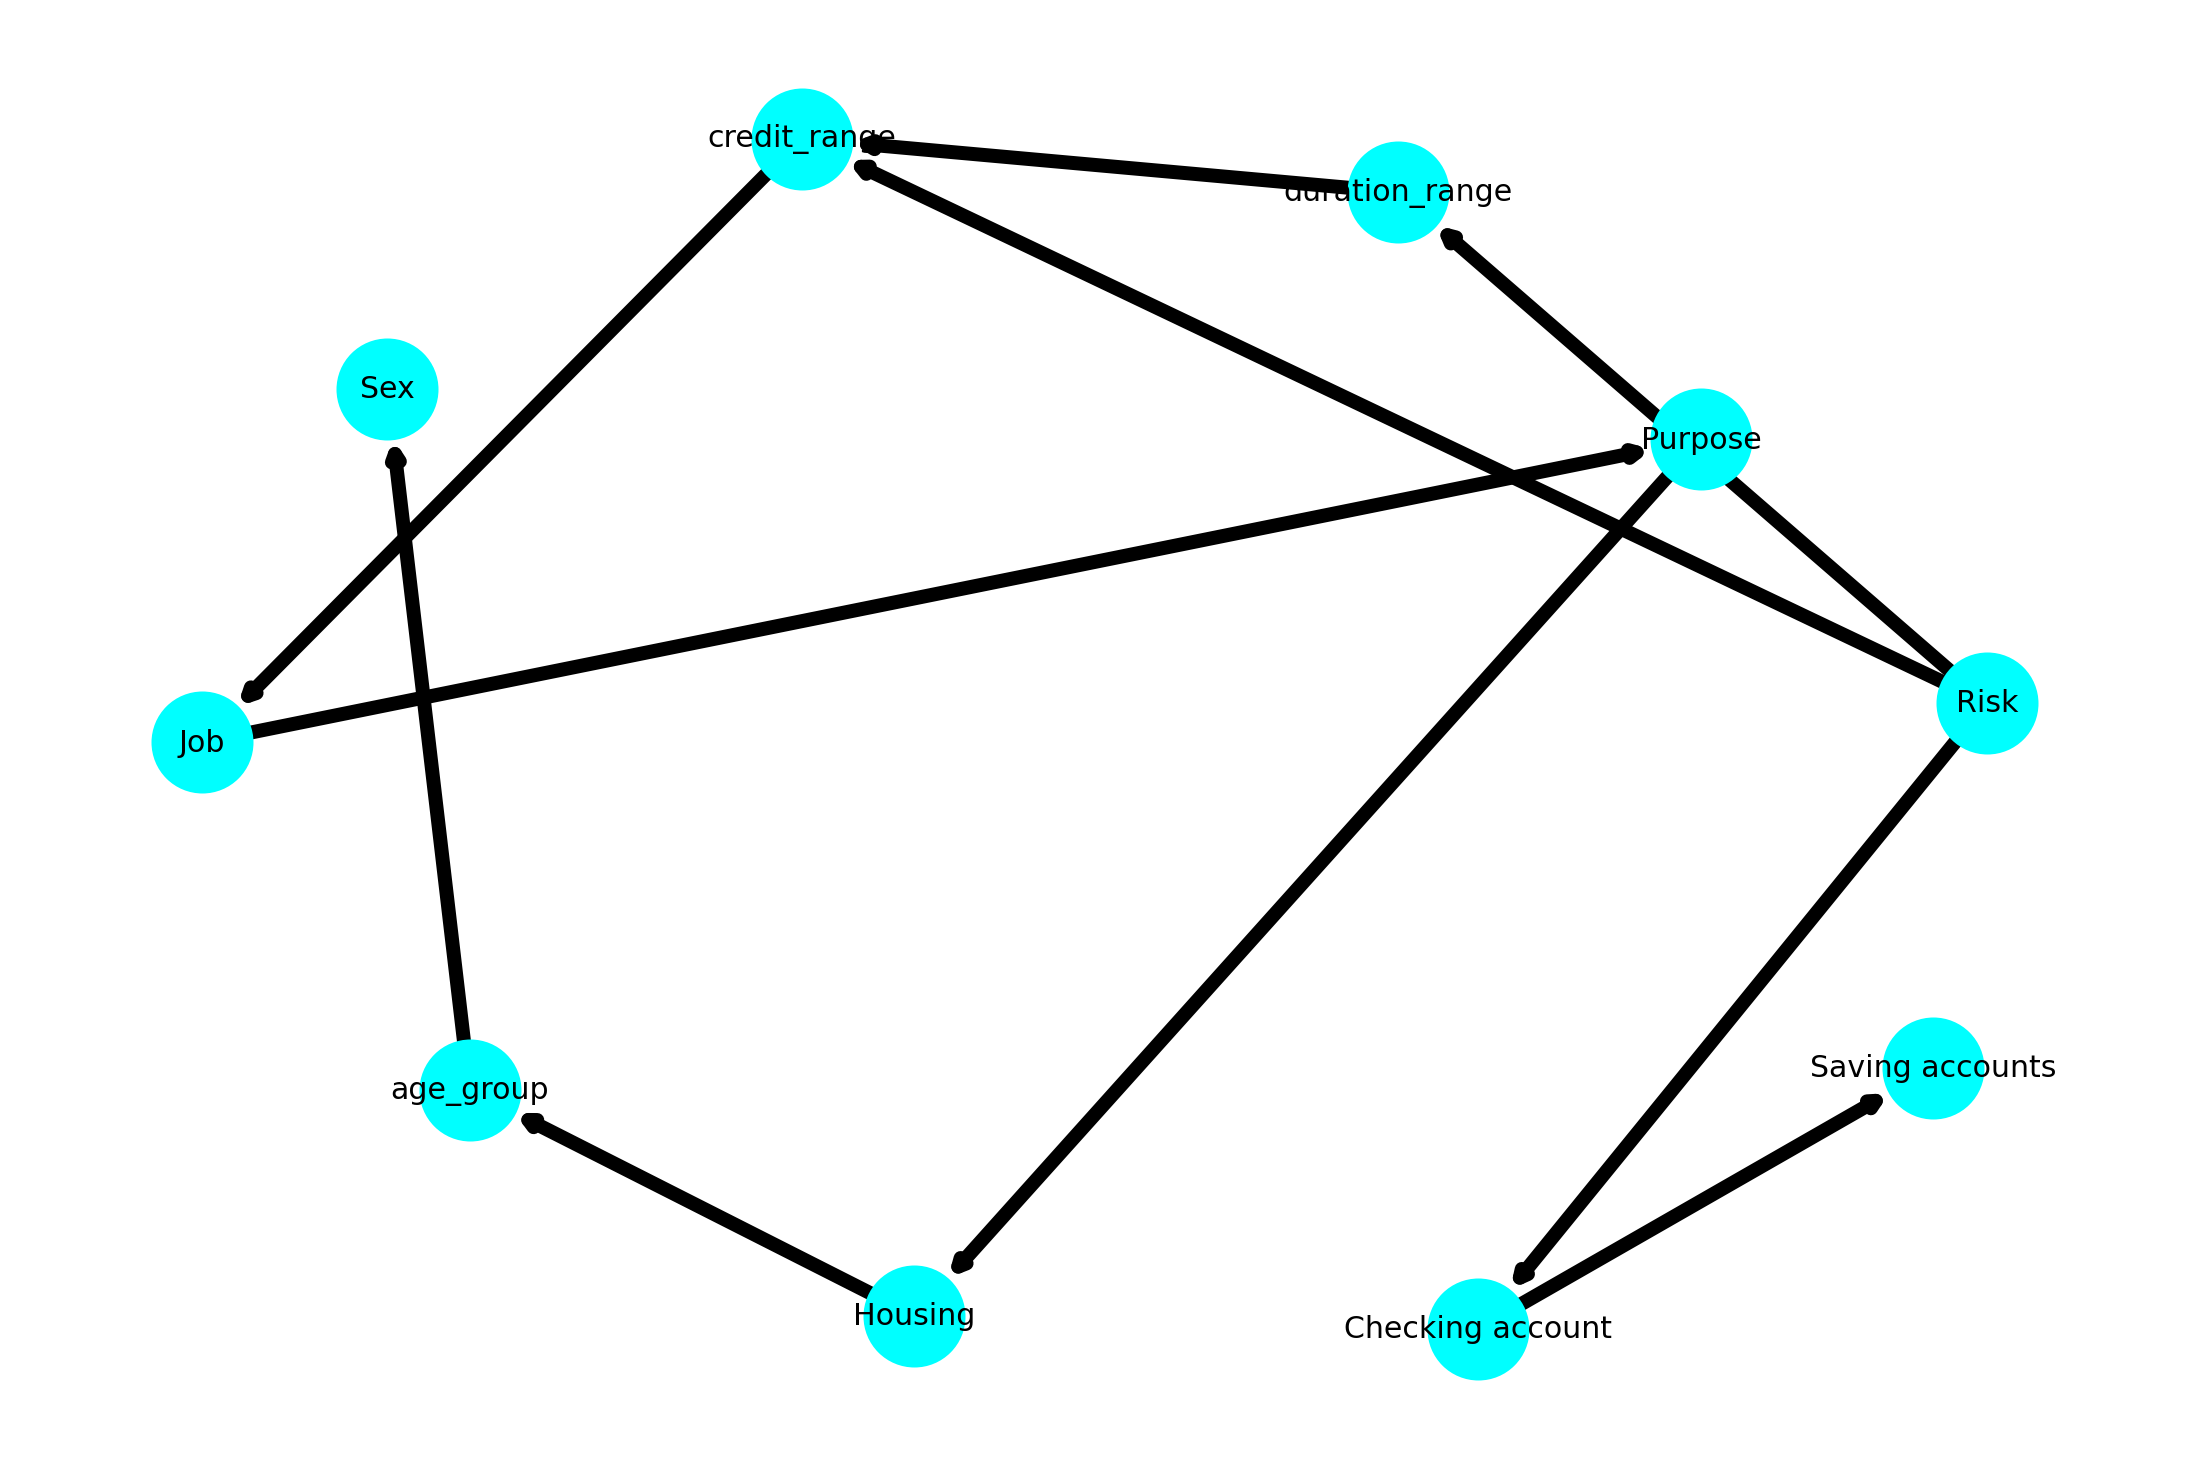

In [67]:
hc = HillClimbSearch(df_train)
best_model = hc.estimate(scoring_method=K2Score(df_train))

edges = list(best_model.edges())
model = BayesianModel(edges)

%matplotlib inline
plt.figure(figsize=(15,10))

nx.draw(model, 
        pos= nx.spring_layout(model), 
        with_labels=True, 
        node_size=2500, 
        node_color="Cyan", 
        width = 7, 
        font_size = 15)
plt.show()

In [68]:
model.fit(df_train, estimator=MaximumLikelihoodEstimator)
test_data = df_test.copy()
test_data.drop('Risk', axis=1, inplace=True)
predictions = model.predict(test_data)

100%|██████████| 194/194 [00:12<00:00, 16.05it/s]


In [69]:
infer = VariableElimination(model)

Classification Report for: Bayesian Network 1
              precision    recall  f1-score   support

         bad       0.56      0.39      0.46        61
        good       0.76      0.86      0.81       139

    accuracy                           0.72       200
   macro avg       0.66      0.63      0.64       200
weighted avg       0.70      0.72      0.70       200



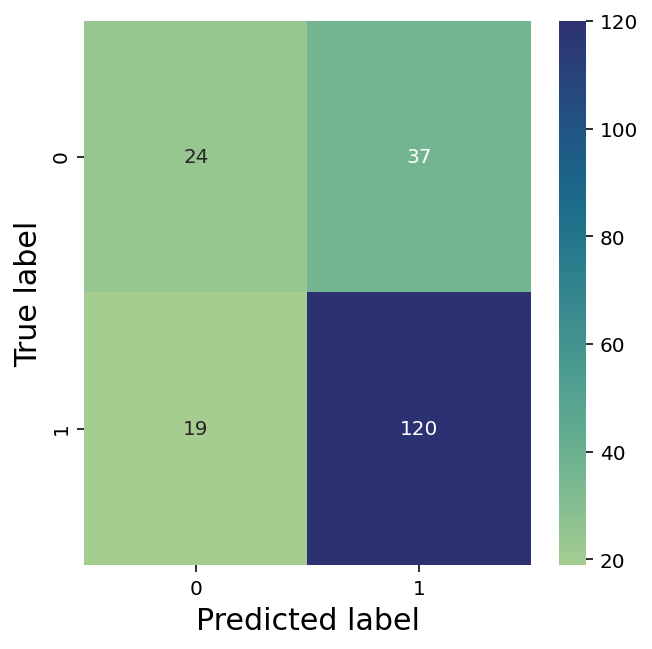

In [60]:
print('Classification Report for: Bayesian Network 1')
print(classification_report(df_test['Risk'], predictions))
print('=========================================================')
plot_conf_mat(df_test['Risk'], predictions)

In [70]:
def precision_v_recall():
    
    mnb_probs = mnb_model.predict_proba(X_test)
    comp_probs = comp_nb_model.predict_proba(X_test)
    cat_probs = cat_nb_model.predict_proba(X_test)
    bn_probs = model.predict_probability(df_test.drop(columns='Risk', axis=1))
    
    
    # ======= Bayesian Network ==============================================
    bn_probs = bn_probs.rename(columns={'Risk_bad':1, 'Risk_good':0})
    df_test_risk = df_test['Risk'].copy()
    df_test_risk = df_test.replace({'Risk':{'good':0, 'bad':1}})['Risk']
    
    bn_probs = bn_probs[1]
    # predict class values
    yhat = model.predict(df_test.drop(columns='Risk', axis=1)).replace({'Risk':{'good':0, 'bad':1}})
    bn_precision, bn_recall, _ = precision_recall_curve(df_test_risk, bn_probs)
    bn_f1, bn_auc = f1_score(df_test_risk, yhat), auc(bn_recall, bn_precision)
    # ========================================================================
    
    # ======= Multinomial Bayes Classifier ==============================================
    mnb_probs = pd.DataFrame(mnb_model.predict_proba(X_test))
    df_test_risk = y_test.copy()
    
    mnb_probs = mnb_probs[1]
    # predict class values
    yhat = mnb_model.predict(X_test)
    mnb_precision, mnb_recall, _ = precision_recall_curve(df_test_risk, mnb_probs)
    mnb_f1, mnb_auc = f1_score(df_test_risk, yhat), auc(mnb_recall, mnb_precision)
    # ========================================================================
    
    # ======= Caterogical Bayesian Classifier ==============================================
    cat_probs = pd.DataFrame(cat_nb_model.predict_proba(X_test))
    df_test_risk = y_test.copy()
    
    cat_probs = cat_probs[1]
    # predict class values
    yhat = cat_nb_model.predict(X_test)
    cat_precision, cat_recall, _ = precision_recall_curve(df_test_risk, cat_probs)
    cat_f1, cat_auc = f1_score(df_test_risk, yhat), auc(cat_recall, cat_precision)
    # ========================================================================
    
    # summarize scores
    print(f'Bayesian Network: f1= {bn_f1:.3f}, auc= {bn_auc:.3f}')
    print(f'Multinomial Naive Bayes: f1= {mnb_f1:.3f}, auc= {mnb_auc:.3f}')
    print(f'Categorical Naive Bayes: f1= {cat_f1:.3f}, auc= {cat_auc:.3f}')
    
    
    # precision-recall curves
    no_skill = len(df_test['Risk'][df_test['Risk']==1]) / len(df_test_risk)
    plt.figure(figsize=(15,10))
    
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(bn_recall, bn_precision, marker='.', label='Bayesian Network')
    plt.plot(mnb_recall, mnb_precision, marker='.', label='Multinomial Naive Bayes')
    plt.plot(cat_recall, cat_precision, marker='.', label='Categorical Naive Bayes')
    
    # axis label
    plt.xlabel('Recall', size=25)
    plt.ylabel('Precision', size=25)
    plt.title('Precision - Recall Curve', size=25)
    
    plt.legend(fontsize=20)
    plt.show()

100%|██████████| 194/194 [00:01<00:00, 101.28it/s]


Bayesian Network: f1= 0.462, auc= 0.538
Multinomial Naive Bayes: f1= 0.313, auc= 0.523
Categorical Naive Bayes: f1= 0.571, auc= 0.576


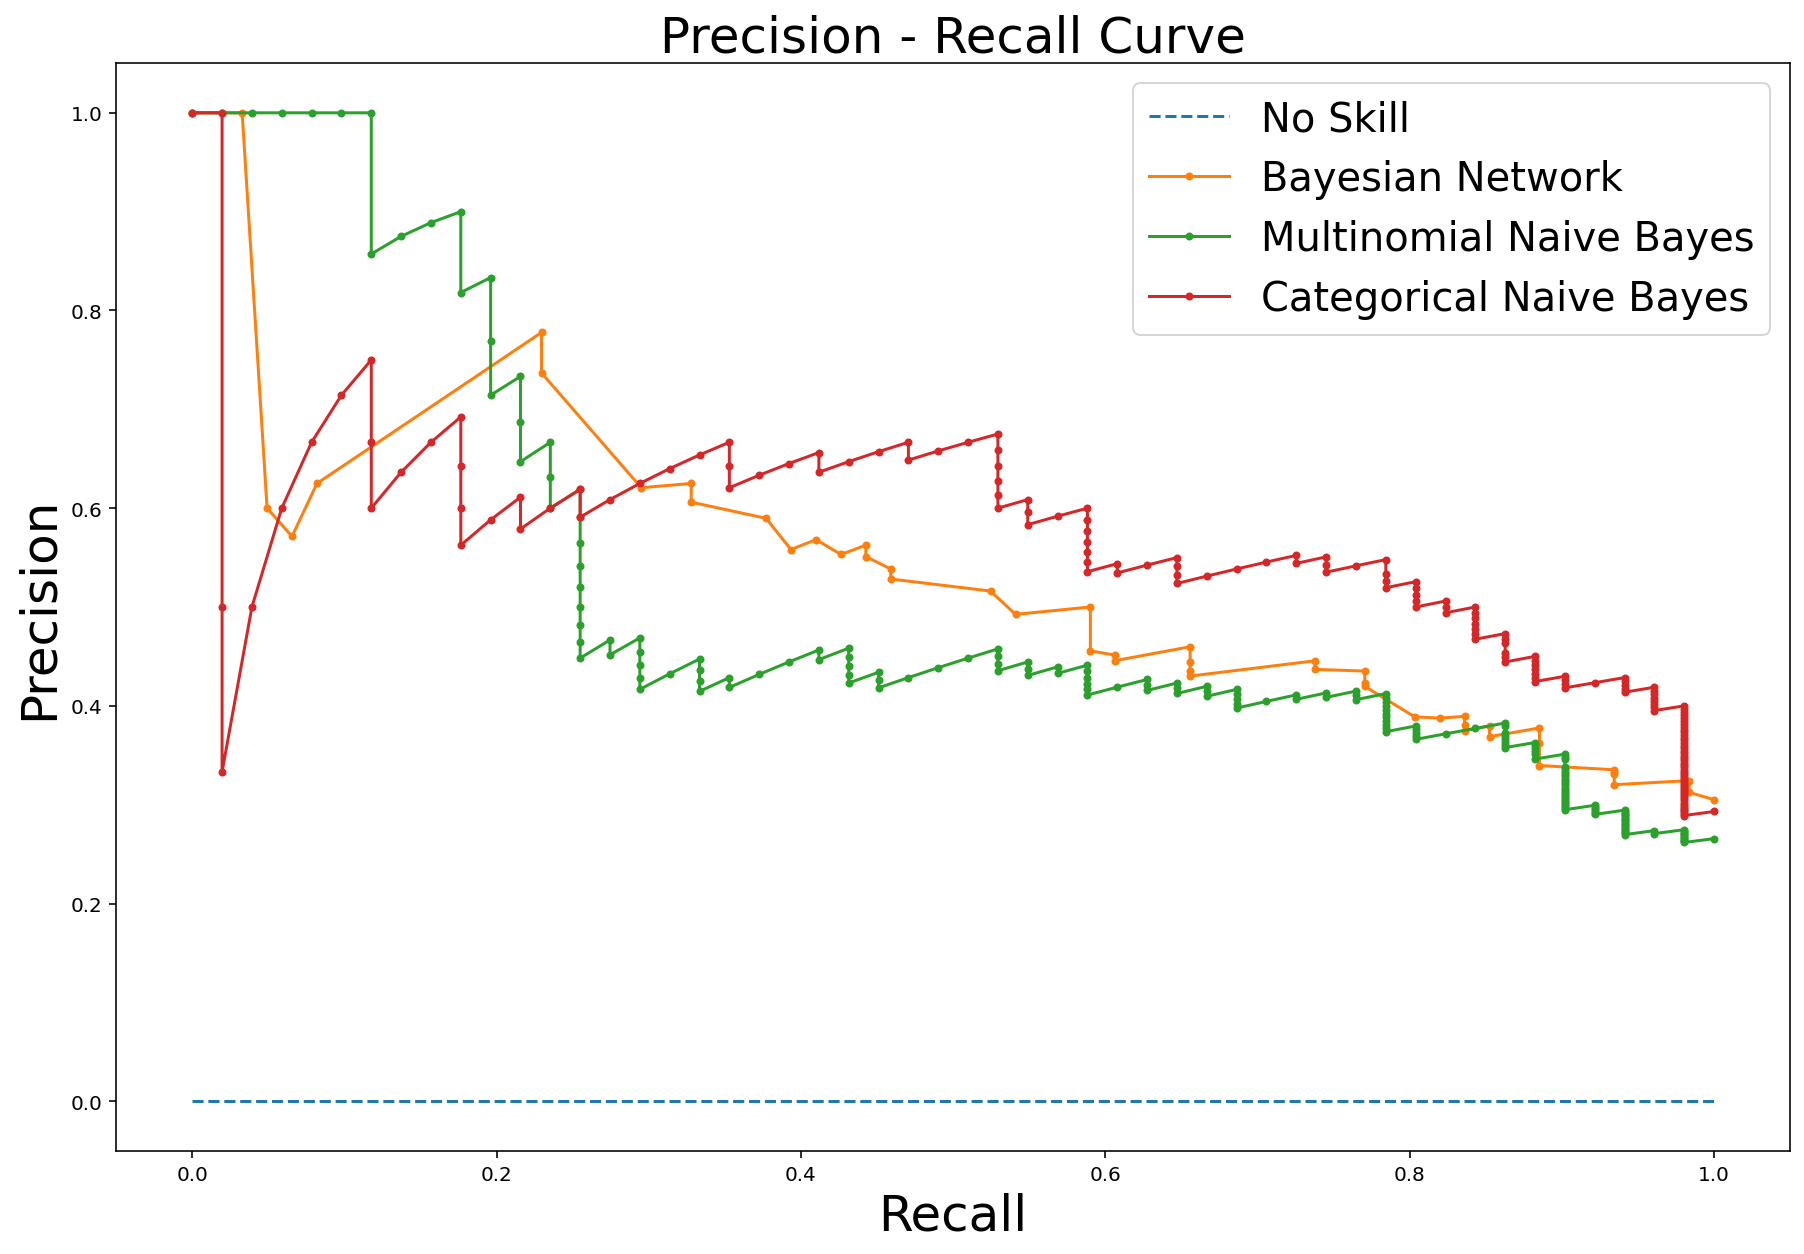

In [71]:
precision_v_recall()

## 7.2 Joint Probabilities

In [34]:
#print(infer.query(variables=['duration_range','credit_range','Risk'], joint=True))

In [35]:
for each in ['shortest','short','long','longest']:
    print("Credit duration:", each)
    print(infer.query(variables=['Risk'], evidence = {'duration_range': each}))

Eliminating: Housing:   0%|          | 0/8 [00:00<?, ?it/s]  

Credit duration: shortest
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.2185 |
+------------+-------------+
| Risk(good) |      0.7815 |
+------------+-------------+
Credit duration: short



Eliminating: credit_range: 100%|██████████| 8/8 [00:00<00:00, 152.56it/s]

Finding Elimination Order: :   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Eliminating: Saving accounts:   0%|          | 0/8 [00:00<?, ?it/s]

Eliminating: age_group:   0%|          | 0/8 [00:00<?, ?it/s]      

Eliminating: Housing:   0%|          | 0/8 [00:00<?, ?it/s]  

Eliminating: Sex:   0%|          | 0/8 [00:00<?, ?it/s]    

Eliminating: Purpose:   0%|          | 0/8 [00:00<?, ?it/s]

Eliminating: Checking account:   0%|          | 0/8 [00:00<?, ?it/s]

Eliminating: Job:   0%|          | 0/8 [00:00<?, ?it/s]             

Eliminating: credit_range: 100%|██████████| 8/8 [00:00<00:00, 187.65it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/8 [00:00<?, ?it/s]


  0%|          | 0/8 [00:00<?, ?it/s]


Eliminating: Saving accounts:   0%|          | 0/8 [00:00<?, ?it/s]


Eliminating: age_group:   0%|          | 0/8 [00:00<?, ?it/s

+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.2828 |
+------------+-------------+
| Risk(good) |      0.7172 |
+------------+-------------+
Credit duration: long
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.2955 |
+------------+-------------+
| Risk(good) |      0.7045 |
+------------+-------------+
Credit duration: longest
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.4520 |
+------------+-------------+
| Risk(good) |      0.5480 |
+------------+-------------+


In [36]:
for each in ['none','little','moderate','rich']:
    print("Checking account:", each)
    print(infer.query(variables=['Risk'], evidence = {'Checking account': each}))




  0%|          | 0/8 [00:00<?, ?it/s]


Finding Elimination Order: :   0%|          | 0/8 [00:00<?, ?it/s]



  0%|          | 0/8 [00:00<?, ?it/s]



Eliminating: Saving accounts:   0%|          | 0/8 [00:00<?, ?it/s]



Eliminating: age_group:   0%|          | 0/8 [00:00<?, ?it/s]      



Eliminating: Housing:   0%|          | 0/8 [00:00<?, ?it/s]  



Eliminating: Sex:   0%|          | 0/8 [00:00<?, ?it/s]    

Checking account: none






Eliminating: Purpose:   0%|          | 0/8 [00:00<?, ?it/s]



Eliminating: duration_range:   0%|          | 0/8 [00:00<?, ?it/s]



Eliminating: Job:   0%|          | 0/8 [00:00<?, ?it/s]           



Finding Elimination Order: : 100%|██████████| 8/8 [00:00<00:00, 100.69it/s]

Finding Elimination Order: :   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Eliminating: Saving accounts:   0%|          | 0/8 [00:00<?, ?it/s]

Eliminating: age_group:   0%|          | 0/8 [00:00<?, ?it/s]      

Eliminating: Housing:   0%|          | 0/8 [00:00<?, ?it/s]  

Eliminating: Sex:   0%|          | 0/8 [00:00<?, ?it/s]    

Eliminating: Purpose:   0%|          | 0/8 [00:00<?, ?it/s]

Eliminating: duration_range:   0%|          | 0/8 [00:00<?, ?it/s]

Eliminating: Job:   0%|          | 0/8 [00:00<?, ?it/s]           

Eliminating: credit_range: 100%|██████████| 8/8 [00:00<00:00, 222.87it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

Finding Elimination Order: :   0%| 

+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.1129 |
+------------+-------------+
| Risk(good) |      0.8871 |
+------------+-------------+
Checking account: little
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.4737 |
+------------+-------------+
| Risk(good) |      0.5263 |
+------------+-------------+
Checking account: moderate


Eliminating: Housing:   0%|          | 0/8 [00:00<?, ?it/s]  


Eliminating: Sex:   0%|          | 0/8 [00:00<?, ?it/s]    


Eliminating: Purpose:   0%|          | 0/8 [00:00<?, ?it/s]


Eliminating: duration_range:   0%|          | 0/8 [00:00<?, ?it/s]


Eliminating: Job:   0%|          | 0/8 [00:00<?, ?it/s]           


Eliminating: credit_range: 100%|██████████| 8/8 [00:00<00:00, 175.32it/s]



  0%|          | 0/8 [00:00<?, ?it/s]


Finding Elimination Order: :   0%|          | 0/8 [00:00<?, ?it/s]



  0%|          | 0/8 [00:00<?, ?it/s]



Eliminating: Saving accounts:   0%|          | 0/8 [00:00<?, ?it/s]



Eliminating: age_group:   0%|          | 0/8 [00:00<?, ?it/s]      



Eliminating: Housing:   0%|          | 0/8 [00:00<?, ?it/s]  



Eliminating: Sex:   0%|          | 0/8 [00:00<?, ?it/s]    



Eliminating: Purpose:   0%|          | 0/8 [00:00<?, ?it/s]



Eliminating: duration_range:   0%|          | 0/8 [00:00<?, ?it/s]



Eliminating: Job:   0%|          | 0/8 [00:

+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.4115 |
+------------+-------------+
| Risk(good) |      0.5885 |
+------------+-------------+
Checking account: rich






Eliminating: credit_range: 100%|██████████| 8/8 [00:00<00:00, 217.47it/s]

+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.2182 |
+------------+-------------+
| Risk(good) |      0.7818 |
+------------+-------------+


In [37]:
for each in ['lowest','low','high','highest']:
    print("Credit amount range:", each)
    print(infer.query(variables=['Risk'], evidence = {'credit_range': each}))





  0%|          | 0/8 [00:00<?, ?it/s]



Finding Elimination Order: :   0%|          | 0/8 [00:00<?, ?it/s]




  0%|          | 0/8 [00:00<?, ?it/s]




Eliminating: Saving accounts:   0%|          | 0/8 [00:00<?, ?it/s]




Eliminating: age_group:   0%|          | 0/8 [00:00<?, ?it/s]      




Eliminating: Housing:   0%|          | 0/8 [00:00<?, ?it/s]  




Eliminating: Sex:   0%|          | 0/8 [00:00<?, ?it/s]    




Eliminating: Purpose:   0%|          | 0/8 [00:00<?, ?it/s]




Eliminating: duration_range:   0%|          | 0/8 [00:00<?, ?it/s]




Eliminating: Checking account:   0%|          | 0/8 [00:00<?, ?it/s]




Eliminating: Job: 100%|██████████| 8/8 [00:00<00:00, 218.01it/s]    





  0%|          | 0/8 [00:00<?, ?it/s]




Finding Elimination Order: :   0%|          | 0/8 [00:00<?, ?it/s]





  0%|          | 0/8 [00:00<?, ?it/s]





Eliminating: Saving accounts:   0%|          | 0/8 [00:00<?, ?it/s]





Eliminating: age_group:   0%|          | 0/8 [00:00<?, ?

Credit amount range: lowest
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.3254 |
+------------+-------------+
| Risk(good) |      0.6746 |
+------------+-------------+
Credit amount range: low








Eliminating: Checking account:   0%|          | 0/8 [00:00<?, ?it/s]





Eliminating: Job: 100%|██████████| 8/8 [00:00<00:00, 223.41it/s]    






  0%|          | 0/8 [00:00<?, ?it/s]





Finding Elimination Order: :   0%|          | 0/8 [00:00<?, ?it/s]






  0%|          | 0/8 [00:00<?, ?it/s]






Eliminating: Saving accounts:   0%|          | 0/8 [00:00<?, ?it/s]








+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.2450 |
+------------+-------------+
| Risk(good) |      0.7550 |
+------------+-------------+
Credit amount range: high


Eliminating: age_group:   0%|          | 0/8 [00:00<?, ?it/s]      






Eliminating: Housing:   0%|          | 0/8 [00:00<?, ?it/s]  






Eliminating: Sex:   0%|          | 0/8 [00:00<?, ?it/s]    






Eliminating: Purpose:   0%|          | 0/8 [00:00<?, ?it/s]






Eliminating: duration_range:   0%|          | 0/8 [00:00<?, ?it/s]






Eliminating: Checking account:   0%|          | 0/8 [00:00<?, ?it/s]






Finding Elimination Order: : 100%|██████████| 8/8 [00:00<00:00, 100.11it/s]

Finding Elimination Order: :   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Eliminating: Saving accounts:   0%|          | 0/8 [00:00<?, ?it/s]

Eliminating: age_group:   0%|          | 0/8 [00:00<?, ?it/s]      

Eliminating: Housing:   0%|          | 0/8 [00:00<?, ?it/s]  

Eliminating: Sex:   0%|          | 0/8 [00:00<?, ?it/s]    

Eliminating: Purpose:   0%|          | 0/8 [00:00<?, ?it/s]

Eliminating: duration_range:   0%|          | 0/8 [00:00<?, ?it/s]

Eli

+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.2051 |
+------------+-------------+
| Risk(good) |      0.7949 |
+------------+-------------+
Credit amount range: highest
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.4184 |
+------------+-------------+
| Risk(good) |      0.5816 |
+------------+-------------+


## 7.3 Conditional Probabilities

### 7.3.1. Conditional probabilities of `Sex` feature given bad credit risk

In [38]:
print(infer.query(variables=['Sex'], evidence={'Risk': 'bad'}))



  0%|          | 0/8 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/8 [00:00<?, ?it/s]


  0%|          | 0/8 [00:00<?, ?it/s]


Eliminating: Saving accounts:   0%|          | 0/8 [00:00<?, ?it/s]


Eliminating: age_group:   0%|          | 0/8 [00:00<?, ?it/s]      


Eliminating: Housing:   0%|          | 0/8 [00:00<?, ?it/s]  


Eliminating: Purpose:   0%|          | 0/8 [00:00<?, ?it/s]


Eliminating: duration_range:   0%|          | 0/8 [00:00<?, ?it/s]


Eliminating: Checking account:   0%|          | 0/8 [00:00<?, ?it/s]


Eliminating: Job:   0%|          | 0/8 [00:00<?, ?it/s]             


Eliminating: credit_range: 100%|██████████| 8/8 [00:00<00:00, 214.68it/s]

+-------------+------------+
| Sex         |   phi(Sex) |
+=============+============+
| Sex(female) |     0.3187 |
+-------------+------------+
| Sex(male)   |     0.6813 |
+-------------+------------+


### 7.3.2. Conditional probabilities of `Job` feature given bad credit risk

In [39]:
print(infer.query(variables=['Job'], evidence={'Risk': 'bad'}))




  0%|          | 0/8 [00:00<?, ?it/s]


Finding Elimination Order: :   0%|          | 0/8 [00:00<?, ?it/s]



  0%|          | 0/8 [00:00<?, ?it/s]



Eliminating: Saving accounts:   0%|          | 0/8 [00:00<?, ?it/s]



Eliminating: age_group:   0%|          | 0/8 [00:00<?, ?it/s]      



Eliminating: Housing:   0%|          | 0/8 [00:00<?, ?it/s]  



Eliminating: Sex:   0%|          | 0/8 [00:00<?, ?it/s]    



Eliminating: Purpose:   0%|          | 0/8 [00:00<?, ?it/s]



Eliminating: duration_range:   0%|          | 0/8 [00:00<?, ?it/s]



Eliminating: Checking account:   0%|          | 0/8 [00:00<?, ?it/s]



Eliminating: credit_range: 100%|██████████| 8/8 [00:00<00:00, 190.20it/s]A

+--------+------------+
| Job    |   phi(Job) |
+========+============+
| Job(0) |     0.0221 |
+--------+------------+
| Job(1) |     0.2008 |
+--------+------------+
| Job(2) |     0.6077 |
+--------+------------+
| Job(3) |     0.1694 |
+--------+------------+


### 7.3.3. Conditional probabilities of `Housing` feature given bad credit risk

In [40]:
print(infer.query(variables=['Housing'], evidence={'Risk': 'bad'}))





  0%|          | 0/8 [00:00<?, ?it/s]



Finding Elimination Order: :   0%|          | 0/8 [00:00<?, ?it/s]




  0%|          | 0/8 [00:00<?, ?it/s]




Eliminating: Saving accounts:   0%|          | 0/8 [00:00<?, ?it/s]




Eliminating: age_group:   0%|          | 0/8 [00:00<?, ?it/s]      




Eliminating: Sex:   0%|          | 0/8 [00:00<?, ?it/s]      




Eliminating: Purpose:   0%|          | 0/8 [00:00<?, ?it/s]




Eliminating: duration_range:   0%|          | 0/8 [00:00<?, ?it/s]




Eliminating: Checking account:   0%|          | 0/8 [00:00<?, ?it/s]




Eliminating: Job:   0%|          | 0/8 [00:00<?, ?it/s]             




Eliminating: credit_range: 100%|██████████| 8/8 [00:00<00:00, 185.68it/s]

+---------------+----------------+
| Housing       |   phi(Housing) |
+===============+================+
| Housing(free) |         0.1134 |
+---------------+----------------+
| Housing(own)  |         0.7117 |
+---------------+----------------+
| Housing(rent) |         0.1749 |
+---------------+----------------+


### 7.3.4. Conditional probabilities of `Saving accounts` feature given bad credit risk

In [41]:
print(infer.query(variables=['Saving accounts'], evidence={'Risk': 'bad'}))






  0%|          | 0/8 [00:00<?, ?it/s]




Finding Elimination Order: :   0%|          | 0/8 [00:00<?, ?it/s]





  0%|          | 0/8 [00:00<?, ?it/s]





Eliminating: age_group:   0%|          | 0/8 [00:00<?, ?it/s]





Eliminating: Housing:   0%|          | 0/8 [00:00<?, ?it/s]  





Eliminating: Sex:   0%|          | 0/8 [00:00<?, ?it/s]    





Eliminating: Purpose:   0%|          | 0/8 [00:00<?, ?it/s]





Eliminating: duration_range:   0%|          | 0/8 [00:00<?, ?it/s]





Eliminating: Checking account:   0%|          | 0/8 [00:00<?, ?it/s]





Eliminating: Job:   0%|          | 0/8 [00:00<?, ?it/s]             





Eliminating: credit_range: 100%|██████████| 8/8 [00:00<00:00, 208.35it/s]

+-----------------------------+------------------------+
| Saving accounts             |   phi(Saving accounts) |
+=============================+========================+
| Saving accounts(little)     |                 0.6449 |
+-----------------------------+------------------------+
| Saving accounts(moderate)   |                 0.1114 |
+-----------------------------+------------------------+
| Saving accounts(none)       |                 0.1528 |
+-----------------------------+------------------------+
| Saving accounts(quite rich) |                 0.0460 |
+-----------------------------+------------------------+
| Saving accounts(rich)       |                 0.0450 |
+-----------------------------+------------------------+


### 7.3.5. Conditional probabilities of `Checking account` feature given bad credit risk

In [42]:
print(infer.query(variables=['Checking account'], evidence={'Risk': 'bad'}))

Finding Elimination Order: : 100%|██████████| 8/8 [00:00<00:00, 79.74it/s]

Finding Elimination Order: :   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Eliminating: Saving accounts:   0%|          | 0/8 [00:00<?, ?it/s]

Eliminating: age_group:   0%|          | 0/8 [00:00<?, ?it/s]      

Eliminating: Housing:   0%|          | 0/8 [00:00<?, ?it/s]  

Eliminating: Sex:   0%|          | 0/8 [00:00<?, ?it/s]    

Eliminating: Purpose:   0%|          | 0/8 [00:00<?, ?it/s]

Eliminating: duration_range:   0%|          | 0/8 [00:00<?, ?it/s]

Eliminating: Job:   0%|          | 0/8 [00:00<?, ?it/s]           

Eliminating: credit_range: 100%|██████████| 8/8 [00:00<00:00, 221.94it/s]

+----------------------------+-------------------------+
| Checking account           |   phi(Checking account) |
+============================+=========================+
| Checking account(little)   |                  0.4142 |
+----------------------------+-------------------------+
| Checking account(moderate) |                  0.3891 |
+----------------------------+-------------------------+
| Checking account(none)     |                  0.1464 |
+----------------------------+-------------------------+
| Checking account(rich)     |                  0.0502 |
+----------------------------+-------------------------+


### 7.3.6. Conditional probabilities of `Purpose` feature given bad credit risk

In [43]:
print(infer.query(variables=['Purpose'], evidence={'Risk': 'bad'}))



  0%|          | 0/8 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/8 [00:00<?, ?it/s]


  0%|          | 0/8 [00:00<?, ?it/s]


Eliminating: Saving accounts:   0%|          | 0/8 [00:00<?, ?it/s]


Eliminating: age_group:   0%|          | 0/8 [00:00<?, ?it/s]      


Eliminating: Housing:   0%|          | 0/8 [00:00<?, ?it/s]  


Eliminating: Sex:   0%|          | 0/8 [00:00<?, ?it/s]    


Eliminating: duration_range:   0%|          | 0/8 [00:00<?, ?it/s]


Eliminating: Checking account:   0%|          | 0/8 [00:00<?, ?it/s]


Eliminating: Job:   0%|          | 0/8 [00:00<?, ?it/s]             


Eliminating: credit_range: 100%|██████████| 8/8 [00:00<00:00, 190.55it/s]

+------------------------------+----------------+
| Purpose                      |   phi(Purpose) |
+==============================+================+
| Purpose(business)            |         0.0967 |
+------------------------------+----------------+
| Purpose(car)                 |         0.3353 |
+------------------------------+----------------+
| Purpose(domestic appliances) |         0.0110 |
+------------------------------+----------------+
| Purpose(education)           |         0.0664 |
+------------------------------+----------------+
| Purpose(furniture/equipment) |         0.1786 |
+------------------------------+----------------+
| Purpose(radio/TV)            |         0.2749 |
+------------------------------+----------------+
| Purpose(repairs)             |         0.0234 |
+------------------------------+----------------+
| Purpose(vacation/others)     |         0.0137 |
+------------------------------+----------------+


### 7.3.7. Conditional probabilities of `age_group` feature given bad credit risk

In [44]:
print(infer.query(variables=['age_group'], evidence={'Risk': 'bad'}))




  0%|          | 0/8 [00:00<?, ?it/s]


Finding Elimination Order: :   0%|          | 0/8 [00:00<?, ?it/s]



  0%|          | 0/8 [00:00<?, ?it/s]



Eliminating: Saving accounts:   0%|          | 0/8 [00:00<?, ?it/s]



Eliminating: Housing:   0%|          | 0/8 [00:00<?, ?it/s]        



Eliminating: Sex:   0%|          | 0/8 [00:00<?, ?it/s]    



Eliminating: Purpose:   0%|          | 0/8 [00:00<?, ?it/s]



Eliminating: duration_range:   0%|          | 0/8 [00:00<?, ?it/s]



Eliminating: Checking account:   0%|          | 0/8 [00:00<?, ?it/s]



Eliminating: Job:   0%|          | 0/8 [00:00<?, ?it/s]             



Eliminating: credit_range: 100%|██████████| 8/8 [00:00<00:00, 160.00it/s]

+-----------------------+------------------+
| age_group             |   phi(age_group) |
+=======================+==================+
| age_group(Elderly)    |           0.0463 |
+-----------------------+------------------+
| age_group(MiddleAged) |           0.3590 |
+-----------------------+------------------+
| age_group(Student)    |           0.1961 |
+-----------------------+------------------+
| age_group(YoungAdult) |           0.3985 |
+-----------------------+------------------+


### 7.3.8. Conditional probabilities of `credit_range` feature given bad credit risk

In [45]:
print(infer.query(variables=['credit_range'], evidence={'Risk': 'bad'}))





  0%|          | 0/8 [00:00<?, ?it/s]



Finding Elimination Order: :   0%|          | 0/8 [00:00<?, ?it/s]




  0%|          | 0/8 [00:00<?, ?it/s]




Eliminating: Saving accounts:   0%|          | 0/8 [00:00<?, ?it/s]




Eliminating: age_group:   0%|          | 0/8 [00:00<?, ?it/s]      




Eliminating: Housing:   0%|          | 0/8 [00:00<?, ?it/s]  




Eliminating: Sex:   0%|          | 0/8 [00:00<?, ?it/s]    




Eliminating: Purpose:   0%|          | 0/8 [00:00<?, ?it/s]




Eliminating: duration_range:   0%|          | 0/8 [00:00<?, ?it/s]




Eliminating: Checking account:   0%|          | 0/8 [00:00<?, ?it/s]




Eliminating: Job: 100%|██████████| 8/8 [00:00<00:00, 192.53it/s]    

+-----------------------+---------------------+
| credit_range          |   phi(credit_range) |
+=======================+=====================+
| credit_range(high)    |              0.1674 |
+-----------------------+---------------------+
| credit_range(highest) |              0.3431 |
+-----------------------+---------------------+
| credit_range(low)     |              0.2050 |
+-----------------------+---------------------+
| credit_range(lowest)  |              0.2845 |
+-----------------------+---------------------+


### 7.3.9. Conditional probabilities of `duration_range` feature given bad credit risk

In [46]:
print(infer.query(variables=['duration_range'], evidence={'Risk': 'bad'}))






  0%|          | 0/8 [00:00<?, ?it/s]




Finding Elimination Order: :   0%|          | 0/8 [00:00<?, ?it/s]





  0%|          | 0/8 [00:00<?, ?it/s]





Eliminating: Saving accounts:   0%|          | 0/8 [00:00<?, ?it/s]





Eliminating: age_group:   0%|          | 0/8 [00:00<?, ?it/s]      





Eliminating: Housing:   0%|          | 0/8 [00:00<?, ?it/s]  





Eliminating: Sex:   0%|          | 0/8 [00:00<?, ?it/s]    





Eliminating: Purpose:   0%|          | 0/8 [00:00<?, ?it/s]





Eliminating: Checking account:   0%|          | 0/8 [00:00<?, ?it/s]





Eliminating: Job:   0%|          | 0/8 [00:00<?, ?it/s]             





Eliminating: credit_range: 100%|██████████| 8/8 [00:00<00:00, 204.78it/s]

+--------------------------+-----------------------+
| duration_range           |   phi(duration_range) |
+==========================+=======================+
| duration_range(long)     |                0.2176 |
+--------------------------+-----------------------+
| duration_range(longest)  |                0.3347 |
+--------------------------+-----------------------+
| duration_range(short)    |                0.1715 |
+--------------------------+-----------------------+
| duration_range(shortest) |                0.2762 |
+--------------------------+-----------------------+


In [73]:

print(infer.query(variables=['duration_range','credit_range','Checking account'], evidence={'Risk':'bad'}))

Eliminating: Sex: 100%|██████████| 6/6 [00:00<00:00, 194.46it/s]

+-----------------------+--------------------------+----------------------------+-----------------------------------------------------+
| credit_range          | duration_range           | Checking account           |   phi(credit_range,duration_range,Checking account) |
+=======================+==========================+============================+=====================================================+
| credit_range(high)    | duration_range(long)     | Checking account(little)   |                                              0.0156 |
+-----------------------+--------------------------+----------------------------+-----------------------------------------------------+
| credit_range(high)    | duration_range(long)     | Checking account(moderate) |                                              0.0147 |
+-----------------------+--------------------------+----------------------------+-----------------------------------------------------+
| credit_range(high)    | duration_range(long)  